# Problem description

https://dengueforecasting.noaa.gov/docs/Metadata.pdf

https://www.ncei.noaa.gov/products/climate-data-records

https://www.ncei.noaa.gov/products/climate-data-records/normalized-difference-vegetation-index

## Setup

Mixed libraries

In [10]:
#!pip install pandas
#!pip install matplotlib
#!pip install seaborn
#!pip install joblib
#!pip install statsmodels
#!pip install tensorflow
#!pip install keras
#!pip install scikit-learn
!pip install tensorflow==2.12.*

  Using cached tensorflow-2.12.0-cp311-cp311-win_amd64.whl (1.9 kB)
  Using cached tensorflow_intel-2.12.0-cp311-cp311-win_amd64.whl (272.9 MB)
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached h5py-3.8.0-cp311-cp311-win_amd64.whl (2.6 MB)
  Using cached jax-0.4.12-py3-none-any.whl
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached grpcio-1.54.2-cp311-cp311-win_amd64.whl (4.1 MB)
  Using cached tensorboard-2.12.3-py3-none-any.whl (5.6 MB)
  Using cached ml_dtypes-0.2.0-cp311-cp311-win_amd64.whl (938 kB)
  Using cached google_auth-2.19.1-py2.py3-none-any.whl (181 kB)
  Using cached google_auth_oauthlib-1.0.0-py2.py3-none-any.whl (18 kB)
  Using cached Markdown-3.4.3-py3-none-any.whl (93 kB)
  Using cached requests-2.31.0-py3-none-any.whl (62 kB)
  Using cached Werkzeug-2.3.6-py

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\marsu\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\tensorflow\\include\\external\\com_github_grpc_grpc\\src\\core\\ext\\filters\\client_channel\\lb_policy\\grpclb\\client_load_reporting_filter.h'
HINT: This error might have occurred since this system does not have Windows Long Path support enabled. You can find information on how to enable this at https://pip.pypa.io/warnings/enable-long-paths



In [7]:
#from google.colab import drive
import os
from copy import deepcopy
from pprint import pprint
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.patches import Circle, ConnectionPatch

from joblib import dump, load

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf#, plot_pair

Sklearn library

In [11]:
#Utilities
from sklearn.metrics import SCORERS
from sklearn.base import clone
# Model
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso, Ridge, LassoCV, SGDRegressor, RidgeCV, ElasticNet, LinearRegression#, TweedieRegressor
from sklearn.svm import SVR
# Model selection 
from sklearn.model_selection import train_test_split, GridSearchCV
# Metrics
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error
# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler
# Feature selection
from sklearn.feature_selection import SelectFromModel, SelectKBest

Keras and Tensorflow

In [13]:
from tensorflow.keras import layers, metrics, losses, Sequential, optimizers, callbacks, preprocessing, activations
import tensorflow as tf

ModuleNotFoundError: No module named 'tensorflow.python'

In [99]:
def null_summary(df, rows=None):
    if rows == None:
        rows = df.shape[0]
    result = pd.concat((df.isnull().sum().rename("Number null"),
                        (100 * df.isnull().sum() / rows).rename("Perc null")),
                       axis=1)
    return result

def impute_nulls(df, columns=None, method="mean"):
    if isinstance(columns, type(None)):
        columns = df.columns
    if method == "mean":
        imputation_values = df[columns].mean().to_dict()
    elif method == "median":
        imputation_values = df[columns].median().to_dict()
    temp = df.copy()
    temp.loc[:, columns] = temp[columns].fillna(imputation_values).copy() # .isnull().sum()
    return temp
    
def extended_describe(dataframe, include="float"):
    # coefficient of variation
    rows = dataframe.shape[0]
    simple_stats = dataframe.describe(include=include).drop(["count"]).T
    simple_stats["90%"] = dataframe.quantile(0.90)
    simple_stats["cv"] = simple_stats["std"].div(simple_stats["mean"])
    # unbiased estimator coefficient of variation
    simple_stats["unbiased_cv"] = (1 + (1 / (4 * rows))) * simple_stats["std"]
    # quartile coefficient of dispersion
    simple_stats["qcd"] = (simple_stats["75%"] - simple_stats["25%"]) / \
        (simple_stats["75%"] + simple_stats["25%"])
    # MAD (deprecated)
    #simple_stats["MAD"] = dataframe.mad()
    # IQR
    simple_stats["IQR"] = simple_stats["75%"] - simple_stats["25%"]

    return simple_stats.T

def extended_describe_serie(serie, include="float"):
    # coefficient of variation
    rows = serie.shape[0]
    simple_stats = serie.describe(include=include).drop(["count"]).T
    simple_stats["90%"] = serie.quantile(0.90)
    simple_stats["cv"] = simple_stats["std"] / simple_stats["mean"]
    # unbiased estimator coefficient of variation
    simple_stats["unbiased_cv"] = (1 + (1 / (4 * rows))) * simple_stats["std"]
    # quartile coefficient of dispersion
    simple_stats["qcd"] = (simple_stats["75%"] - simple_stats["25%"]) / \
        (simple_stats["75%"] + simple_stats["25%"])
    # MAD
    simple_stats["MAD"] = serie.mad()
    # IQR
    simple_stats["IQR"] = simple_stats["75%"] - simple_stats["25%"]

    return simple_stats.T

def multi_boxplot_hist(df, bins=None, axes_fc="lightgray", fig_fc="gray", figsize=(14, 24)):
    temp = df.select_dtypes(float)
    number_rows, number_columns = temp.shape
    fig, axes = plt.subplots(number_columns - 1, 2, figsize=(10, 24))

    fig.set_facecolor(fig_fc)
    if bins == None:
      bins = int(np.sqrt(number_rows))
    
    for column, ax in zip(temp.columns, axes):
      sns.boxplot(data=temp, x=column, ax=ax[0], orient="h")
      ax[0].set_facecolor(axes_fc)
      sns.histplot(data=temp, x=column, ax=ax[1], bins=bins)
      ax[1].set_facecolor(axes_fc)
      #sns.violinplot(data=temp, y=column, inner="points", ax=ax[2], alpha=0.6) # , palette="light:g"
    plt.tight_layout()

def multi_plot_numerical(df, which_plot="boxplot", IQR_prop=2.0, bins=None, stat="probability", axes_fc="lightgray", fig_fc="gray"):
    temp = df.select_dtypes(float)
    number_rows, number_columns = temp.shape
    fig, axes = plt.subplots(number_columns - 1, 1, figsize=(16, 24))
    fig.set_facecolor(fig_fc)

    if which_plot == "hist":
        if bins == None:
            bins = int(np.sqrt(number_rows))

    for column, ax in zip(temp.columns, axes):
      if which_plot == "hist":
          sns.histplot(data=temp, x=column, ax=ax, bins=bins, stat=stat)
          ax.set_facecolor(axes_fc)
      else:
          sns.boxplot(data=temp, x=column, 
                      ax=ax, 
                      orient="h", 
                      whis=IQR_prop, 
                      showmeans=True,
                      meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"}
                      )
          sns.stripplot(data=temp, x=column, ax=ax, orient="h", color="red", 
                        alpha=0.2,
                        size=1
                        )
          ax.set_facecolor(axes_fc)
    plt.tight_layout()
    
def detect_outliers_IQR_serie(serie, IQR_prop=1.5):
    # test function: pass a serie
    stats = extended_describe_serie(serie)
    Q1, Q3, IQR = stats.loc[["25%", "75%", "IQR"]]
    # returns data points which are NOT between the range
    return ~serie.between(Q1 - IQR_prop * IQR, Q3 + IQR_prop * IQR)

def detect_outliers_IQR_df(df, IQR_prop=1.5):
    # test function: pass a dataframe
    stats = extended_describe(df)
    temp = df.copy()
    for col in temp.columns:
        Q1, Q3, IQR = stats.loc[["25%", "75%", "IQR"], col]
        # returns data points which are NOT between the range
        temp[col] = ~temp[col].between(Q1 - IQR_prop * IQR, Q3 + IQR_prop * IQR)
    return temp.astype(int)

def correct_outliers_to_IQR(df, IQR_prop=1.5, full_bounded=False, low_bounded=False, up_bounded=False, custom_bounds=(0.0, 100.0)):
    temp = df.copy()
    stats = extended_describe(temp)
    lower_bound, upper_bound = custom_bounds
    print('column | bot_value | top_value | IQR | Q3')

    for col in temp.columns:
      Q1, Q3, IQR = stats.loc[["25%", "75%", "IQR"], col]
      top_val = Q3 + IQR_prop * IQR
      bot_val = Q1 - IQR_prop * IQR
      if full_bounded:
        top_val = np.array([top_val])
        bot_val = np.array([bot_val])

        top_val = np.clip(top_val, lower_bound, upper_bound)[0]
        bot_val = np.clip(bot_val, lower_bound, upper_bound)[0]
      elif low_bounded:
        bot_val = lower_bound if bot_val < lower_bound else bot_val
      elif up_bounded:
        top_val =  upper_bound if top_val > upper_bound else top_val
      print(col, bot_val, top_val, IQR, Q3)
      
      # Correct lower outliers
      temp.loc[:, col] = temp[col].where(temp[col] >= bot_val, bot_val)
      # Correct upper outliers
      temp.loc[:, col] = temp[col].where(temp[col] <= top_val, top_val)
    return temp

In [15]:
def plot_pair(df, pairs, main_col, figsize=(12, 12), cols=4):
  number_columns = len(pairs)
  extra_rows = (cols - number_columns % cols)
  fig, axes = plt.subplots((number_columns + extra_rows) // cols, cols, figsize=figsize)
  
  for ax, sec_column in zip(axes.ravel(), pairs[main_col]):
    ax.scatter(df[sec_column], df[main_col])
    ax.set_xlabel(sec_column)
    ax.set_ylabel(main_col)
  plt.tight_layout()

In [55]:
def read_data(name_data="dengue_features_train.csv", name_target="dengue_labels_train.csv", on_train=True):
  data = training_features = pd.read_csv(name_data, index_col='week_start_date')

  training_labels = pd.read_csv(name_target)

  if on_train:
    data = data.reset_index().merge(training_labels, how='inner', on=['city', 'year', 'weekofyear']).set_index('week_start_date')
    data.total_cases = data.total_cases.astype(float)

  city_to_integer = {'sj': 0, 'iq':1}

  data.city = data.city.replace(city_to_integer).astype(int)

  data.index = pd.to_datetime(data.index, yearfirst=True, format='%Y-%m-%d', infer_datetime_format=True)

  return data

def mag_homogenized(df):
  KELVIN_TO_CELSIUS = 273.15
  RANDOM_STATE = 117  
  temp = df.copy()

  temp.loc[:, 'reanalysis_max_air_temp_c'] = \
    temp.loc[:, 'reanalysis_max_air_temp_k'] - KELVIN_TO_CELSIUS

  temp.loc[:, 'reanalysis_min_air_temp_c'] = \
    temp.loc[:, 'reanalysis_min_air_temp_k'] - KELVIN_TO_CELSIUS
  
  temp.loc[:, 'reanalysis_avg_temp_c'] = \
    temp.loc[:, 'reanalysis_avg_temp_k'] - KELVIN_TO_CELSIUS

  temp.loc[:, 'reanalysis_dew_point_temp_c'] = \
    temp.loc[:, 'reanalysis_dew_point_temp_k'] - KELVIN_TO_CELSIUS
  
  temp.loc[:, 'reanalysis_air_temp_c'] = \
    temp.loc[:, 'reanalysis_air_temp_k'] - KELVIN_TO_CELSIUS

  to_drop = ['reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_avg_temp_k',
             'reanalysis_dew_point_temp_k', 'reanalysis_air_temp_k', 'reanalysis_sat_precip_amt_mm'
             ]
  temp.rename(columns={'reanalysis_tdtr_k': 'reanalysis_tdtr_c'}, inplace=True)
  temp.drop(to_drop, axis=1, inplace=True)

  return temp

def outlier_correction(df, IQR_prop=3.0, on_full_unbounded=False, lower_bounded_cols=None, bounded_cols=None, non_treated=None):
  temp = df.copy()
  lower_bounded_cols = ['precipitation_amt_mm', 
                        'reanalysis_precip_amt_kg_per_m2',
                        #'reanalysis_sat_precip_amt_mm',
                        'reanalysis_specific_humidity_g_per_kg',
                        'reanalysis_tdtr_c',
                        'station_diur_temp_rng_c',
                        'station_precip_mm'
                        ]

  bounded_cols = ['reanalysis_relative_humidity_percent']

  non_treated = ['total_cases']

  all_columns = temp.select_dtypes(float).columns
  
  unbounded_cols = [c for c in all_columns if c not in (lower_bounded_cols + bounded_cols + non_treated)]

  print(len(lower_bounded_cols), len(bounded_cols), len(non_treated), len(unbounded_cols), len(all_columns))
  print(unbounded_cols)
  # Unbounded features
  temp.loc[:, unbounded_cols] = correct_outliers_to_IQR(temp[unbounded_cols], IQR_prop=IQR_prop)

  if on_full_unbounded:
    return temp
  
  # lower-bound features
  temp.loc[:, lower_bounded_cols] = correct_outliers_to_IQR(temp[lower_bounded_cols], IQR_prop=IQR_prop, low_bounded=True)

  # bounded features (percentage)
  temp.loc[:, bounded_cols] = correct_outliers_to_IQR(temp[bounded_cols], IQR_prop=IQR_prop, full_bounded=True, custom_bounds=(0.0, 100.0))

  # custom bounded features (input bounds)
  #temp.loc[:, custom_bounded_cols] = correct_outliers_to_IQR(temp[bounded_cols], IQR_prop=IQR_prop, full_bounded=True, custom_bounds=())

  return temp

def null_correction(df, strategy='KNN'):
  temp = df.copy()
  
  if strategy == 'KNN':
    from sklearn.impute import KNNImputer
    knn_imputer = KNNImputer()
    temp.loc[:, temp.select_dtypes(float).columns] = knn_imputer.fit_transform(temp.select_dtypes(float))
  elif strategy == 'iter':
    from sklearn.impute import IterativeImputer
    iter_imputer = IterativeImputer()
    temp.loc[:, temp.select_dtypes(float).columns] = iter_imputer.fit_transform(temp.select_dtypes(float))
  elif strategy in ['mean', 'median']:
    from sklearn.impute import SimpleImputer
    simple_imputer = SimpleImputer(strategy=strategy)
    temp.loc[:, temp.select_dtypes(float).columns] = simple_imputer.fit_transform(temp.select_dtypes(float))
  return temp

def drop_features_from_reanalysis(df):
  reanalysis_to_drop = ['reanalysis_max_air_temp_c',
                        'reanalysis_min_air_temp_c',
                        'reanalysis_avg_temp_c',
                        'reanalysis_air_temp_c',
                        'reanalysis_tdtr_c',
                        #'reanalysis_sat_precip_amt_mm',
                        ]
  temp = df.copy()
  temp.drop(reanalysis_to_drop, axis=1, inplace=True)
  return temp

def weekofyear_to_season(df, on_dummies=True):
  temp = df.index.to_series().copy()
  seasonInt_to_season = {1: "winter", 2: "spring", 3: "summer", 4: "fall"}
  if on_dummies:
    dummy_cols = pd.get_dummies((temp.dt.month % 12 // 3 + 1).replace(seasonInt_to_season), prefix='is', drop_first=True)
    return pd.concat((df, dummy_cols), axis=1)
  else:
    return (temp.dt.month % 12 // 3 + 1).replace(seasonInt_to_season).rename('season')

def weekofyear_to_month(df, on_dummies=True):
  temp = df.index.to_series().copy()
  monthInt_to_month = {1: "January", 2: "February", 3: "March", 4: "April", 
                       5: "May", 6: "June", 7: "July", 8: "August", 
                       9: "September", 10: "October", 11: "November", 12: "December"}
  if on_dummies:
    dummy_cols = pd.get_dummies((temp.dt.month).replace(monthInt_to_month), prefix='is', drop_first=True)
    return pd.concat((df, dummy_cols), axis=1)
  else:
    return (temp.dt.month).replace(monthInt_to_month).rename('month')

def weekofmonth_to_dummies(df):
  intweek_to_strweek = {0: "firstweek", 
                         1: "secondweek", 
                         2: "thirdweek", 
                         3: "fourthweek"
                         }
  weekofmonth = ((df.weekofyear.unique() - 1) % 4 ).replace(intweek_to_strweek)
  dummy_cols = pd.get_dummies(weekofmonth, 
                              prefix='is', 
                              drop_first=True)
  return pd.concat((df, dummy_cols), axis=1)

def add_features_functions(df, reject_target='total_cases'):
  temp = df.drop(reject_target, axis='columns', errors='ignore').copy()

  df_to_sqrt = temp.select_dtypes(float).iloc[:, 4:].applymap(lambda x: np.sqrt(1 + x)).copy()
  df_to_sqrt.columns = [col + '_sqrt' for col in df_to_sqrt.columns]

  #df_to_square = temp.select_dtypes(float).applymap(np.square).copy()
  #df_to_square.columns = [col + '_square' for col in df_to_square.columns]

  return pd.concat((df.copy(), df_to_sqrt), axis=1)

def add_features_ndvi(df):
  temp = df.copy()

  ndvi_cols = ['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw']
  ndvi_data = temp.loc[:, ndvi_cols]

  for n, col1 in enumerate(ndvi_cols):
    for col2 in ndvi_cols[n + 1:]:
        temp[col1 + col2[4:]] = (ndvi_data.loc[:, col1] - ndvi_data.loc[:, col2])
        print(col1 + col2[4:])
  return temp

def shift_1_week(df, shift_direc=-1):
  temp = df.copy()
  
  shifted_target = temp.loc[:, ['city', 'total_cases']].groupby('city').shift(shift_direc)
  # forward fill na values in target
  temp.loc[:, 'total_cases'] = shifted_target.fillna(method='ffill')

  return temp

def detect_uncorrelated(df, corr_limit=0.3, strategy='limit', threshold_lim=3):
  temp = df.copy()
  total_cols = temp.columns
  corr_mat = df.select_dtypes(float).corr().abs()
  float_cols = corr_mat.columns
  
  col_to_correlated_cols = {}
  cols_with_correlations = []

  for n, col1 in enumerate(float_cols):
    col_to_correlated_cols[col1] = []
    for col2 in float_cols[n + 1:]:
      if corr_mat.loc[col1, col2] >= corr_limit:
        col_to_correlated_cols[col1].append(col2)

    if strategy == 'limit':
      if len(col_to_correlated_cols[col1]) >= threshold_lim:
        cols_with_correlations.append(col1)

  # columns enough correlations, columns with few correlations
  #return cols_with_correlations, [c for c in total_cols if c not in cols_with_correlations]
  return temp.loc[:, [c for c in total_cols if c not in cols_with_correlations]]

def extract_transform(name_data="dengue_features_train.csv", name_target="dengue_labels_train.csv", remove_corelated=True):
  data = read_data(name_data="dengue_features_train.csv", name_target="dengue_labels_train.csv", on_train=True)

  data = mag_homogenized(data)

  data = outlier_correction(data, IQR_prop=3.0)

  data = null_correction(data)

  data = drop_features_from_reanalysis(data)

  #data = weekofyear_to_season(data, on_dummies=True)
  
  data = weekofyear_to_month(data, on_dummies=True)

  data = weekofmonth_to_dummies(data)

  #data = add_features_functions(data, reject_target='total_cases')

  #data = add_features_ndvi(data)

  #data = shift_1_week(data)

  if remove_corelated:
    data = detect_uncorrelated(data, corr_limit=0.3, strategy='limit', threshold_lim=2)
  
  return data

In [56]:
def plot_predictions_line(model, x, y, threshold=2, metric=mean_absolute_error, legend_label_sufix='training', linewidth=0.5, on_circles=False, on_connections=False, figsize=(12, 8)):
  fig, axes = plt.subplots(1, 1, figsize=figsize)
  fig.set_facecolor('silver')

  color_pred = 'forestgreen'
  color_true = 'blue'
  color_error = 'red'

  y_pred = model.predict(x)
  train_error = abs(y_pred -  y) #metric(model.predict(x), y)
  warnings = train_error >= threshold

  x_warn = np.arange(x.shape[0])[warnings]
  y_warn = y_pred[warnings]
  y_true_warn = y[warnings]

  # Plot Predictions
  #axes.scatter(np.arange(x.shape[0]), y_pred, s=5, c=color_pred, label='predicted_' + legend_label_sufix, alpha=0.5) # #linestyle='dashed',
  axes.plot(np.arange(x.shape[0]), y_pred, linewidth=linewidth, markersize=5, color=color_pred, label='predicted_' + legend_label_sufix, alpha=0.5)

  if on_circles or on_connections:
    # Add patches
    for pos_x, pos_y, pos_y_true in zip(x_warn, y_warn, y_true_warn):
      if on_circles:
        circle = Circle(xy=(pos_x, pos_y), radius=5, fill=False, color='red', alpha=0.8)
        axes.add_patch(circle)
      if on_connections:
        con = ConnectionPatch(
            # x in axes coordinates, y in axes coordinates
            #xyA=(pos_x, pos_y), coordsA=ax2.transAxes,
            # x in axes coordinates, y in data coordinates
            #xyA=(pos_x, pos_y), coordsA=axes.get_yaxis_transform(),
            # x in data coordinates, y in data coordinates
            xyA=(pos_x, pos_y), coordsA=axes.transData,
            xyB=(pos_x, pos_y_true), coordsB=axes.transData,
            arrowstyle="->", 
            color='tomato'
            )
        axes.add_patch(con)
  #else:
  # Plot Predictions with warnings
  axes.scatter(x_warn, y_warn, s=5, c=color_error, label='predicted_training_warn')

  # Plot Target
  #axes.plot(np.arange(x.shape[0]), y, linewidth=linewidth, markersize=5, color=color_true, label='true_' + legend_label_sufix, alpha=0.5)
  axes.scatter(np.arange(x.shape[0]), y, s=5, c=color_true, label='true_' + legend_label_sufix, alpha=0.5)
  axes.legend()
  axes.set_xlabel('Date')
  axes.set_ylabel('Total_cases')
  score = metric(y, y_pred)
  print(f'MAE metric: {score}\n')
  return fig, axes, score

def fit_and_evaluate(model, X_tr, X_ts, y_tr, y_ts, weights=None, on_clone=False, on_fit=True):
  if on_fit:
    if on_clone:
      model = clone(model)
    try:
      model.fit(X_tr, y_tr, sample_weight=weights)
    except:
      print('(does not support or have weighting) ', end='')
      model.fit(X_tr, y_tr)
  score_train, score_test = mean_absolute_error(y_tr, model.predict(X_tr)), mean_absolute_error(y_ts, model.predict(X_ts))
    
  print(str(model).split('(')[0])
  print(score_train, score_test, '\n')
  return model

In [8]:
drive.mount("Drive")

Mounted at Drive


In [9]:
path_to_data = os.path.join('Drive', 'MyDrive', 'Data and datasets', 'Dengue')
path_to_data

'Drive/MyDrive/Data and datasets/Dengue'

In [10]:
os.listdir(path_to_data)

['dengue_features_test.csv',
 'dengue_features_train.csv',
 'dengue_labels_train.csv',
 'submission_format.csv',
 'SVR.joblib',
 'best_mode_weighted_forest.joblib',
 'best_model_weighted_forest.joblib',
 'SGDRegressor.joblib',
 'DecisionTreeRegressor.joblib',
 'RandomForestRegressor.joblib',
 'Lasso.joblib',
 'Ridge.joblib',
 'SVR_rbf.joblib',
 'SVR_poly.joblib',
 'SVR_linear.joblib',
 'model.png']

In [18]:
os.listdir()

['.git',
 '.gitignore',
 'DengAI_ Predicting Disease Spread_analysis.ipynb',
 'DengAI_ Predicting Disease Spread_Modeling.ipynb',
 'dengue_features_test.csv',
 'dengue_features_train.csv',
 'dengue_labels_train.csv',
 'README.md']

In [11]:
os.chdir(path_to_data)

Constants

In [19]:
KELVIN_TO_CELSIUS = 273.15
RANDOM_STATE = 117

## Read training and test data

In [116]:
training_features = pd.read_csv("dengue_features_train.csv",
                                parse_dates=["week_start_date"],
                                index_col='week_start_date')
test_features = pd.read_csv("dengue_features_test.csv",
                            parse_dates=["week_start_date"],
                            index_col='week_start_date')
training_labels = pd.read_csv("dengue_labels_train.csv")

Join target and dataset

In [117]:
training_features = training_features.reset_index().merge(training_labels, how='inner', on=['city', 'year', 'weekofyear']).set_index('week_start_date')
training_features.total_cases = training_features.total_cases.astype(float)

transform city to itneger

In [118]:
city_to_integer = {'sj': 0, 'iq':1}

training_features.city = training_features.city.replace(city_to_integer).astype(int)
test_features.city = test_features.city.replace(city_to_integer).astype(int)

In [119]:
training_features.head()

city  year  weekofyear   ndvi_ne   ndvi_nw   ndvi_se  \
week_start_date                                                         
1990-04-30          0  1990          18  0.122600  0.103725  0.198483   
1990-05-07          0  1990          19  0.169900  0.142175  0.162357   
1990-05-14          0  1990          20  0.032250  0.172967  0.157200   
1990-05-21          0  1990          21  0.128633  0.245067  0.227557   
1990-05-28          0  1990          22  0.196200  0.262200  0.251200   

                  ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  \
week_start_date                                                          
1990-04-30       0.177617                 12.42             297.572857   
1990-05-07       0.155486                 22.82             298.211429   
1990-05-14       0.170843                 34.54             298.781429   
1990-05-21       0.235886                 15.36             298.987143   
1990-05-28       0.247340                  7.52             299.518571   

                 reanalysis_avg_temp_k  ...  \
week_start_date                         ...   
1990-04-30                  297.742857  ...   
1990-05-07                  298.442857  ...   
1990-05-14                  298.878571  ...   
1990-05-21                  299.228571  ...   
1990-05-28                  299.664286  ...   

                 reanalysis_relative_humidity_percent  \
week_start_date                                         
1990-04-30                                  73.365714   
1990-05-07                                  77.368571   
1990-05-14                                  82.052857   
1990-05-21                                  80.337143   
1990-05-28                                  80.460000   

                 reanalysis_sat_precip_amt_mm  \
week_start_date                                 
1990-04-30                              12.42   
1990-05-07                              22.82   
1990-05-14                              34.54   
1990-05-21                              15.36   
1990-05-28                               7.52   

                 reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
week_start_date                                                             
1990-04-30                                   14.012857           2.628571   
1990-05-07                                   15.372857           2.371429   
1990-05-14                                   16.848571           2.300000   
1990-05-21                                   16.672857           2.428571   
1990-05-28                                   17.210000           3.014286   

                 station_avg_temp_c  station_diur_temp_rng_c  \
week_start_date                                                
1990-04-30                25.442857                 6.900000   
1990-05-07                26.714286                 6.371429   
1990-05-14                26.714286                 6.485714   
1990-05-21                27.471429                 6.771429   
1990-05-28                28.942857                 9.371429   

                 station_max_temp_c  station_min_temp_c  station_precip_mm  \
week_start_date                                                              
1990-04-30                     29.4                20.0               16.0   
1990-05-07                     31.7                22.2                8.6   
1990-05-14                     32.2                22.8               41.4   
1990-05-21                     33.3                23.3                4.0   
1990-05-28                     35.0                23.9                5.8   

                 total_cases  
week_start_date               
1990-04-30               4.0  
1990-05-07               5.0  
1990-05-14               4.0  
1990-05-21               3.0  
1990-05-28               6.0  

[5 rows x 24 columns]

In [120]:
test_features.head()

city  year  weekofyear  ndvi_ne   ndvi_nw   ndvi_se  \
week_start_date                                                        
2008-04-29          0  2008          18  -0.0189 -0.018900  0.102729   
2008-05-06          0  2008          19  -0.0180 -0.012400  0.082043   
2008-05-13          0  2008          20  -0.0015       NaN  0.151083   
2008-05-20          0  2008          21      NaN -0.019867  0.124329   
2008-05-27          0  2008          22   0.0568  0.039833  0.062267   

                  ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  \
week_start_date                                                          
2008-04-29       0.091200                 78.60             298.492857   
2008-05-06       0.072314                 12.56             298.475714   
2008-05-13       0.091529                  3.66             299.455714   
2008-05-20       0.125686                  0.00             299.690000   
2008-05-27       0.075914                  0.76             299.780000   

                 reanalysis_avg_temp_k  ...  reanalysis_precip_amt_kg_per_m2  \
week_start_date                         ...                                    
2008-04-29                  298.550000  ...                            25.37   
2008-05-06                  298.557143  ...                            21.83   
2008-05-13                  299.357143  ...                             4.12   
2008-05-20                  299.728571  ...                             2.20   
2008-05-27                  299.671429  ...                             4.36   

                 reanalysis_relative_humidity_percent  \
week_start_date                                         
2008-04-29                                  78.781429   
2008-05-06                                  78.230000   
2008-05-13                                  78.270000   
2008-05-20                                  73.015714   
2008-05-27                                  74.084286   

                 reanalysis_sat_precip_amt_mm  \
week_start_date                                 
2008-04-29                              78.60   
2008-05-06                              12.56   
2008-05-13                               3.66   
2008-05-20                               0.00   
2008-05-27                               0.76   

                 reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
week_start_date                                                             
2008-04-29                                   15.918571           3.128571   
2008-05-06                                   15.791429           2.571429   
2008-05-13                                   16.674286           4.428571   
2008-05-20                                   15.775714           4.342857   
2008-05-27                                   16.137143           3.542857   

                 station_avg_temp_c  station_diur_temp_rng_c  \
week_start_date                                                
2008-04-29                26.528571                 7.057143   
2008-05-06                26.071429                 5.557143   
2008-05-13                27.928571                 7.785714   
2008-05-20                28.057143                 6.271429   
2008-05-27                27.614286                 7.085714   

                 station_max_temp_c  station_min_temp_c  station_precip_mm  
week_start_date                                                             
2008-04-29                     33.3                21.7               75.2  
2008-05-06                     30.0                22.2               34.3  
2008-05-13                     32.8                22.8                3.0  
2008-05-20                     33.3                24.4                0.3  
2008-05-27                     33.3                23.3               84.1  

[5 rows x 23 columns]

Check weekofyear variable

In [121]:
training_features.shape, training_labels.shape, test_features.shape, 

((1456, 24), (1456, 4), (416, 23))

Show sample of labels

In [122]:
training_labels.head()

city  year  weekofyear  total_cases
0   sj  1990          18            4
1   sj  1990          19            5
2   sj  1990          20            4
3   sj  1990          21            3
4   sj  1990          22            6

In [123]:
training_labels.describe().iloc[3:].T

min      25%     50%      75%     max
year         1990.0  1997.00  2002.0  2005.00  2010.0
weekofyear      1.0    13.75    26.5    39.25    53.0
total_cases     0.0     5.00    12.0    28.00   461.0

- We see a 20 years time span.

Detailed descriptions of some variables

station_diur_temp_rng_c: difference between the maximum and minimum

Some features come from different sources and have different scales. For example, ones from sensors on the surface. Others from satellite-based devices:

1. station_precip_mm, precipitation_amt_mm, reanalysis_sat_precip_amt_mm and reanalysis_precip_amt_kg_per_m2.
1. reanalysis_max/min_air_temp_k and station_max/min_temp_c.
1. station_avg_temp_c and reanalysis_avg_temp_k.
1. reanalysis_tdtr_k and station_diur_temp_rng_c

In [124]:
training_features.describe().T

count         mean        std  \
city                                   1456.0     0.357143   0.479322   
year                                   1456.0  2001.031593   5.408314   
weekofyear                             1456.0    26.503434  15.019437   
ndvi_ne                                1262.0     0.142294   0.140531   
ndvi_nw                                1404.0     0.130553   0.119999   
ndvi_se                                1434.0     0.203783   0.073860   
ndvi_sw                                1434.0     0.202305   0.083903   
precipitation_amt_mm                   1443.0    45.760388  43.715537   
reanalysis_air_temp_k                  1446.0   298.701852   1.362420   
reanalysis_avg_temp_k                  1446.0   299.225578   1.261715   
reanalysis_dew_point_temp_k            1446.0   295.246356   1.527810   
reanalysis_max_air_temp_k              1446.0   303.427109   3.234601   
reanalysis_min_air_temp_k              1446.0   295.719156   2.565364   
reanalysis_precip_amt_kg_per_m2        1446.0    40.151819  43.434399   
reanalysis_relative_humidity_percent   1446.0    82.161959   7.153897   
reanalysis_sat_precip_amt_mm           1443.0    45.760388  43.715537   
reanalysis_specific_humidity_g_per_kg  1446.0    16.746427   1.542494   
reanalysis_tdtr_k                      1446.0     4.903754   3.546445   
station_avg_temp_c                     1413.0    27.185783   1.292347   
station_diur_temp_rng_c                1413.0     8.059328   2.128568   
station_max_temp_c                     1436.0    32.452437   1.959318   
station_min_temp_c                     1442.0    22.102150   1.574066   
station_precip_mm                      1434.0    39.326360  47.455314   
total_cases                            1456.0    24.675137  43.596000   

                                               min          25%          50%  \
city                                      0.000000     0.000000     0.000000   
year                                   1990.000000  1997.000000  2002.000000   
weekofyear                                1.000000    13.750000    26.500000   
ndvi_ne                                  -0.406250     0.044950     0.128817   
ndvi_nw                                  -0.456100     0.049217     0.121429   
ndvi_se                                  -0.015533     0.155087     0.196050   
ndvi_sw                                  -0.063457     0.144209     0.189450   
precipitation_amt_mm                      0.000000     9.800000    38.340000   
reanalysis_air_temp_k                   294.635714   297.658929   298.646429   
reanalysis_avg_temp_k                   294.892857   298.257143   299.289286   
reanalysis_dew_point_temp_k             289.642857   294.118929   295.640714   
reanalysis_max_air_temp_k               297.800000   301.000000   302.400000   
reanalysis_min_air_temp_k               286.900000   293.900000   296.200000   
reanalysis_precip_amt_kg_per_m2           0.000000    13.055000    27.245000   
reanalysis_relative_humidity_percent     57.787143    77.177143    80.301429   
reanalysis_sat_precip_amt_mm              0.000000     9.800000    38.340000   
reanalysis_specific_humidity_g_per_kg    11.715714    15.557143    17.087143   
reanalysis_tdtr_k                         1.357143     2.328571     2.857143   
station_avg_temp_c                       21.400000    26.300000    27.414286   
station_diur_temp_rng_c                   4.528571     6.514286     7.300000   
station_max_temp_c                       26.700000    31.100000    32.800000   
station_min_temp_c                       14.700000    21.100000    22.200000   
station_precip_mm                         0.000000     8.700000    23.850000   
total_cases                               0.000000     5.000000    12.000000   

                                               75%          max  
city                                      1.000000     1.000000  
year                                   2005.000000  2010.000000  
weekofyear     

In [125]:
training_features.reanalysis_air_temp_k

week_start_date
1990-04-30    297.572857
1990-05-07    298.211429
1990-05-14    298.781429
1990-05-21    298.987143
1990-05-28    299.518571
                 ...    
2010-05-28    299.334286
2010-06-04    298.330000
2010-06-11    296.598571
2010-06-18    296.345714
2010-06-25    298.097143
Name: reanalysis_air_temp_k, Length: 1456, dtype: float64

### Show null values

In [126]:
null_summary(training_features)

Number null  Perc null
city                                             0   0.000000
year                                             0   0.000000
weekofyear                                       0   0.000000
ndvi_ne                                        194  13.324176
ndvi_nw                                         52   3.571429
ndvi_se                                         22   1.510989
ndvi_sw                                         22   1.510989
precipitation_amt_mm                            13   0.892857
reanalysis_air_temp_k                           10   0.686813
reanalysis_avg_temp_k                           10   0.686813
reanalysis_dew_point_temp_k                     10   0.686813
reanalysis_max_air_temp_k                       10   0.686813
reanalysis_min_air_temp_k                       10   0.686813
reanalysis_precip_amt_kg_per_m2                 10   0.686813
reanalysis_relative_humidity_percent            10   0.686813
reanalysis_sat_precip_amt_mm                    13   0.892857
reanalysis_specific_humidity_g_per_kg           10   0.686813
reanalysis_tdtr_k                               10   0.686813
station_avg_temp_c                              43   2.953297
station_diur_temp_rng_c                         43   2.953297
station_max_temp_c                              20   1.373626
station_min_temp_c                              14   0.961538
station_precip_mm                               22   1.510989
total_cases                                      0   0.000000

ndvi_ne has 13.3 % of null values

### Show unique values

In [127]:
training_features.nunique().T.sort_values()

city                                        2
year                                       21
weekofyear                                 53
station_min_temp_c                         73
station_max_temp_c                         73
reanalysis_min_air_temp_k                 117
total_cases                               135
reanalysis_max_air_temp_k                 141
station_diur_temp_rng_c                   470
station_avg_temp_c                        492
reanalysis_tdtr_k                         519
reanalysis_avg_temp_k                     600
station_precip_mm                         663
reanalysis_precip_amt_kg_per_m2          1039
precipitation_amt_mm                     1157
reanalysis_sat_precip_amt_mm             1157
reanalysis_specific_humidity_g_per_kg    1171
reanalysis_air_temp_k                    1176
reanalysis_dew_point_temp_k              1180
ndvi_ne                                  1214
ndvi_nw                                  1365
reanalysis_relative_humidity_perce

We can say that *city*, *year*, *weekofyear* and *week_start_date* are categorical variables.

## Homogenize magnitudes

1. Precipitations

In [128]:
precip_cols = ['station_precip_mm', 'precipitation_amt_mm', 'reanalysis_sat_precip_amt_mm']
training_features[precip_cols].head()

station_precip_mm  precipitation_amt_mm  \
week_start_date                                            
1990-04-30                    16.0                 12.42   
1990-05-07                     8.6                 22.82   
1990-05-14                    41.4                 34.54   
1990-05-21                     4.0                 15.36   
1990-05-28                     5.8                  7.52   

                 reanalysis_sat_precip_amt_mm  
week_start_date                                
1990-04-30                              12.42  
1990-05-07                              22.82  
1990-05-14                              34.54  
1990-05-21                              15.36  
1990-05-28                               7.52

In [129]:
filter = training_features.precipitation_amt_mm.notnull() & training_features.reanalysis_sat_precip_amt_mm.notnull()

(training_features[filter].precipitation_amt_mm == training_features[filter].reanalysis_sat_precip_amt_mm).all()

True

precipitation_amt_mm AND reanalysis_sat_precip_amt_mm are equivalent. We will drop *reanalysis_sat_precip_amt_mm*.

Absolute differences

In [130]:
(training_features.station_precip_mm - training_features.precipitation_amt_mm).diff().abs().describe()

count    1409.000000
mean       43.241718
std        47.899159
min         0.000000
25%        12.200000
50%        28.790000
75%        58.500000
max       572.410000
dtype: float64

In [131]:
(training_features.station_precip_mm - training_features.precipitation_amt_mm).diff().abs().describe()

count    1409.000000
mean       43.241718
std        47.899159
min         0.000000
25%        12.200000
50%        28.790000
75%        58.500000
max       572.410000
dtype: float64

2. Extreme temperatures

In [132]:
ext_temperature_cols = ['reanalysis_max_air_temp_k', 
                        'reanalysis_min_air_temp_k', 
                        'station_max_temp_c',
                        'station_min_temp_c']

training_features[ext_temperature_cols].head()

reanalysis_max_air_temp_k  reanalysis_min_air_temp_k  \
week_start_date                                                         
1990-04-30                           299.8                      295.9   
1990-05-07                           300.9                      296.4   
1990-05-14                           300.5                      297.3   
1990-05-21                           301.4                      297.0   
1990-05-28                           301.9                      297.5   

                 station_max_temp_c  station_min_temp_c  
week_start_date                                          
1990-04-30                     29.4                20.0  
1990-05-07                     31.7                22.2  
1990-05-14                     32.2                22.8  
1990-05-21                     33.3                23.3  
1990-05-28                     35.0                23.9

Kelvin scale is the standard magnitude for temperature, but we will use Celsius.

In [133]:
training_features[ext_temperature_cols].head()

reanalysis_max_air_temp_k  reanalysis_min_air_temp_k  \
week_start_date                                                         
1990-04-30                           299.8                      295.9   
1990-05-07                           300.9                      296.4   
1990-05-14                           300.5                      297.3   
1990-05-21                           301.4                      297.0   
1990-05-28                           301.9                      297.5   

                 station_max_temp_c  station_min_temp_c  
week_start_date                                          
1990-04-30                     29.4                20.0  
1990-05-07                     31.7                22.2  
1990-05-14                     32.2                22.8  
1990-05-21                     33.3                23.3  
1990-05-28                     35.0                23.9

3. Average temperatures

In [134]:
temperature_cols = ['station_avg_temp_c',
                    'reanalysis_avg_temp_k',
                    'reanalysis_air_temp_k'
                    ]

training_features[temperature_cols].head()

station_avg_temp_c  reanalysis_avg_temp_k  \
week_start_date                                              
1990-04-30                25.442857             297.742857   
1990-05-07                26.714286             298.442857   
1990-05-14                26.714286             298.878571   
1990-05-21                27.471429             299.228571   
1990-05-28                28.942857             299.664286   

                 reanalysis_air_temp_k  
week_start_date                         
1990-04-30                  297.572857  
1990-05-07                  298.211429  
1990-05-14                  298.781429  
1990-05-21                  298.987143  
1990-05-28                  299.518571

In [135]:
training_features[temperature_cols].head()

station_avg_temp_c  reanalysis_avg_temp_k  \
week_start_date                                              
1990-04-30                25.442857             297.742857   
1990-05-07                26.714286             298.442857   
1990-05-14                26.714286             298.878571   
1990-05-21                27.471429             299.228571   
1990-05-28                28.942857             299.664286   

                 reanalysis_air_temp_k  
week_start_date                         
1990-04-30                  297.572857  
1990-05-07                  298.211429  
1990-05-14                  298.781429  
1990-05-21                  298.987143  
1990-05-28                  299.518571

absolute differences

In [136]:
# station_avg_temp_c y reanalysis_avg_temp_k
(training_features.station_avg_temp_c - training_features.reanalysis_avg_temp_k).diff().abs().describe()

count    1.380000e+03
mean     5.510868e-01
std      5.354398e-01
min      5.684342e-14
25%      1.747024e-01
50%      3.928571e-01
75%      7.428571e-01
max      4.235714e+00
dtype: float64

In [137]:
# reanalysis_avg_temp_k y reanalysis_air_temp_k
(training_features.reanalysis_avg_temp_k - training_features.reanalysis_air_temp_k).diff().abs().describe()

count    1.435000e+03
mean     1.785246e-01
std      2.125226e-01
min      9.999894e-10
25%      4.428572e-02
50%      1.014286e-01
75%      2.164286e-01
max      1.690000e+00
dtype: float64

4. Temperature ranges

In [138]:
temperature_ranges_cols = [
                           'reanalysis_tdtr_k',
                           'station_diur_temp_rng_c'
                           ]

training_features[temperature_ranges_cols].head()

reanalysis_tdtr_k  station_diur_temp_rng_c
week_start_date                                            
1990-04-30                2.628571                 6.900000
1990-05-07                2.371429                 6.371429
1990-05-14                2.300000                 6.485714
1990-05-21                2.428571                 6.771429
1990-05-28                3.014286                 9.371429

If we subtract the max and min temperatures of reanalysis variables...

In [139]:
training_features.reanalysis_max_air_temp_k - training_features.reanalysis_min_air_temp_k

week_start_date
1990-04-30     3.9
1990-05-07     4.5
1990-05-14     3.2
1990-05-21     4.4
1990-05-28     4.4
              ... 
2010-05-28    15.2
2010-06-04    16.6
2010-06-11    13.1
2010-06-18    14.2
2010-06-25    15.5
Length: 1456, dtype: float64

In [140]:
training_features.station_max_temp_c - training_features.station_min_temp_c

week_start_date
1990-04-30     9.4
1990-05-07     9.5
1990-05-14     9.4
1990-05-21    10.0
1990-05-28    11.1
              ... 
2010-05-28    13.0
2010-06-04    13.0
2010-06-11    13.0
2010-06-18    10.2
2010-06-25    11.5
Length: 1456, dtype: float64

We see that they are not equal to the temperature shown in reanalysis_tdtr_k

6. Dew point

average temperature is always less than dew point.

In [141]:
filter = training_features.reanalysis_air_temp_k.notnull() & training_features.reanalysis_dew_point_temp_k.notnull()
(training_features[filter].reanalysis_air_temp_k >= training_features[filter].reanalysis_dew_point_temp_k).all()

True

It is not false because there are null values

Summarization of actions:

1. Drop either precipitation_amt_mm or reanalysis_sat_precip_amt_mm column. They are duplicates.

In [142]:
def mag_homogenized(df):
  temp = df.copy()

  temp.loc[:, 'reanalysis_max_air_temp_c'] = \
    temp.loc[:, 'reanalysis_max_air_temp_k'] - KELVIN_TO_CELSIUS

  temp.loc[:, 'reanalysis_min_air_temp_c'] = \
    temp.loc[:, 'reanalysis_min_air_temp_k'] - KELVIN_TO_CELSIUS
  
  temp.loc[:, 'reanalysis_avg_temp_c'] = \
    temp.loc[:, 'reanalysis_avg_temp_k'] - KELVIN_TO_CELSIUS

  temp.loc[:, 'reanalysis_dew_point_temp_c'] = \
    temp.loc[:, 'reanalysis_dew_point_temp_k'] - KELVIN_TO_CELSIUS
  
  temp.loc[:, 'reanalysis_air_temp_c'] = \
    temp.loc[:, 'reanalysis_air_temp_k'] - KELVIN_TO_CELSIUS

  to_drop = ['reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_avg_temp_k',
             'reanalysis_dew_point_temp_k', 'reanalysis_air_temp_k', 'reanalysis_sat_precip_amt_mm'
             ]
  temp.rename(columns={'reanalysis_tdtr_k': 'reanalysis_tdtr_c'}, inplace=True)
  temp.drop(to_drop, axis=1, inplace=True)

  return temp

In [143]:
training_features_mag_homo = mag_homogenized(training_features)

In [144]:
training_features_mag_homo.describe().T

count         mean        std  \
city                                   1456.0     0.357143   0.479322   
year                                   1456.0  2001.031593   5.408314   
weekofyear                             1456.0    26.503434  15.019437   
ndvi_ne                                1262.0     0.142294   0.140531   
ndvi_nw                                1404.0     0.130553   0.119999   
ndvi_se                                1434.0     0.203783   0.073860   
ndvi_sw                                1434.0     0.202305   0.083903   
precipitation_amt_mm                   1443.0    45.760388  43.715537   
reanalysis_precip_amt_kg_per_m2        1446.0    40.151819  43.434399   
reanalysis_relative_humidity_percent   1446.0    82.161959   7.153897   
reanalysis_specific_humidity_g_per_kg  1446.0    16.746427   1.542494   
reanalysis_tdtr_c                      1446.0     4.903754   3.546445   
station_avg_temp_c                     1413.0    27.185783   1.292347   
station_diur_temp_rng_c                1413.0     8.059328   2.128568   
station_max_temp_c                     1436.0    32.452437   1.959318   
station_min_temp_c                     1442.0    22.102150   1.574066   
station_precip_mm                      1434.0    39.326360  47.455314   
total_cases                            1456.0    24.675137  43.596000   
reanalysis_max_air_temp_c              1446.0    30.277109   3.234601   
reanalysis_min_air_temp_c              1446.0    22.569156   2.565364   
reanalysis_avg_temp_c                  1446.0    26.075578   1.261715   
reanalysis_dew_point_temp_c            1446.0    22.096356   1.527810   
reanalysis_air_temp_c                  1446.0    25.551852   1.362420   

                                               min          25%          50%  \
city                                      0.000000     0.000000     0.000000   
year                                   1990.000000  1997.000000  2002.000000   
weekofyear                                1.000000    13.750000    26.500000   
ndvi_ne                                  -0.406250     0.044950     0.128817   
ndvi_nw                                  -0.456100     0.049217     0.121429   
ndvi_se                                  -0.015533     0.155087     0.196050   
ndvi_sw                                  -0.063457     0.144209     0.189450   
precipitation_amt_mm                      0.000000     9.800000    38.340000   
reanalysis_precip_amt_kg_per_m2           0.000000    13.055000    27.245000   
reanalysis_relative_humidity_percent     57.787143    77.177143    80.301429   
reanalysis_specific_humidity_g_per_kg    11.715714    15.557143    17.087143   
reanalysis_tdtr_c                         1.357143     2.328571     2.857143   
station_avg_temp_c                       21.400000    26.300000    27.414286   
station_diur_temp_rng_c                   4.528571     6.514286     7.300000   
station_max_temp_c                       26.700000    31.100000    32.800000   
station_min_temp_c                       14.700000    21.100000    22.200000   
station_precip_mm                         0.000000     8.700000    23.850000   
total_cases                               0.000000     5.000000    12.000000   
reanalysis_max_air_temp_c                24.650000    27.850000    29.250000   
reanalysis_min_air_temp_c                13.750000    20.750000    23.050000   
reanalysis_avg_temp_c                    21.742857    25.107143    26.139286   
reanalysis_dew_point_temp_c              16.492857    20.968929    22.490714   
reanalysis_air_temp_c                    21.485714    24.508929    25.496429   

                                               75%          max  
city                                      1.000000     1.000000  
year                                   2005.000000  2010.000000  
weekofyear                               39.250000    53.000000  
ndvi_ne                                   0.248483     0.508357  
ndvi_nw                             

In [145]:
training_features_mag_homo.columns

Index(['city', 'year', 'weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se',
       'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_c',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'total_cases',
       'reanalysis_max_air_temp_c', 'reanalysis_min_air_temp_c',
       'reanalysis_avg_temp_c', 'reanalysis_dew_point_temp_c',
       'reanalysis_air_temp_c'],
      dtype='object')

## EDA

#### NDVI

NDVI differences

In [146]:
ndvi_cols = ['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'city']
ndvi_data = training_features_mag_homo.loc[:, ndvi_cols]

Statistics

In [147]:
ndvi_data.describe().T

count      mean       std       min       25%       50%       75%  \
ndvi_ne  1262.0  0.142294  0.140531 -0.406250  0.044950  0.128817  0.248483   
ndvi_nw  1404.0  0.130553  0.119999 -0.456100  0.049217  0.121429  0.216600   
ndvi_se  1434.0  0.203783  0.073860 -0.015533  0.155087  0.196050  0.248846   
ndvi_sw  1434.0  0.202305  0.083903 -0.063457  0.144209  0.189450  0.246982   
city     1456.0  0.357143  0.479322  0.000000  0.000000  0.000000  1.000000   

              max  
ndvi_ne  0.508357  
ndvi_nw  0.454429  
ndvi_se  0.538314  
ndvi_sw  0.546017  
city     1.000000

In [148]:
ndvi_data.groupby('city').agg(['mean', 'std']).T

city                 0         1
ndvi_ne mean  0.057925  0.263869
        std   0.107153  0.081370
ndvi_nw mean  0.067469  0.238783
        std   0.092479  0.076751
ndvi_se mean  0.177655  0.250126
        std   0.057166  0.077354
ndvi_sw mean  0.165956  0.266779
        std   0.056073  0.086345

1. ndvi_ne, ndvi_nw are moderately low with low deviation for 1, in contrast with 0, where is low.
2. ndvi_se and ndvi_sw are moderately low for both cities, a bit higher for 1. STD are arguably similar.

In [149]:
"""
for col1 in ndvi_cols:
  for col2 in ndvi_cols[::-1]:
    if col1 !=col2:
      diff_mean_ndvi = (ndvi_data.loc[:, col1] - ndvi_data.loc[:, col2]).mean()
      print(col1 + ' - ' + col2 + ':', diff_mean_ndvi)
"""

for n, col1 in enumerate(ndvi_cols[:-1]):
  for col2 in ndvi_cols[:-1][n + 1:]:
      diff_mean_ndvi = (ndvi_data.loc[:, col1] - ndvi_data.loc[:, col2]).mean()
      print(col1 + ' - ' + col2 + ':', diff_mean_ndvi)

ndvi_ne - ndvi_nw: 0.00554944642548077
ndvi_ne - ndvi_se: -0.06431862968304279
ndvi_ne - ndvi_sw: -0.0648202592947702
ndvi_nw - ndvi_se: -0.0740262040968661
ndvi_nw - ndvi_sw: -0.07252399653062677
ndvi_se - ndvi_sw: 0.001477698314504883


#### Inspection of target (total_cases)

In [150]:
examples = training_features_mag_homo.shape[0]

(<Axes: >, 38)

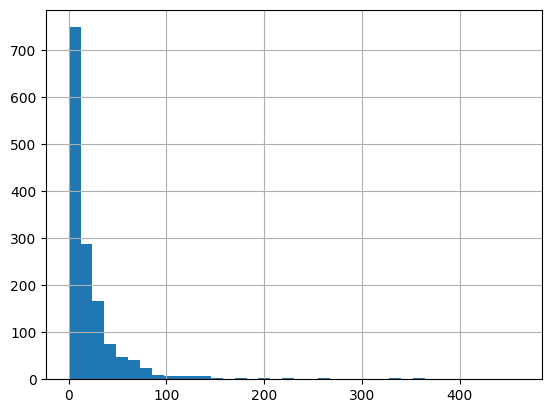

In [151]:
int_bins = bins=int(np.sqrt(examples))
training_features_mag_homo.total_cases.hist(bins=int_bins), int_bins

<Axes: xlabel='total_cases'>

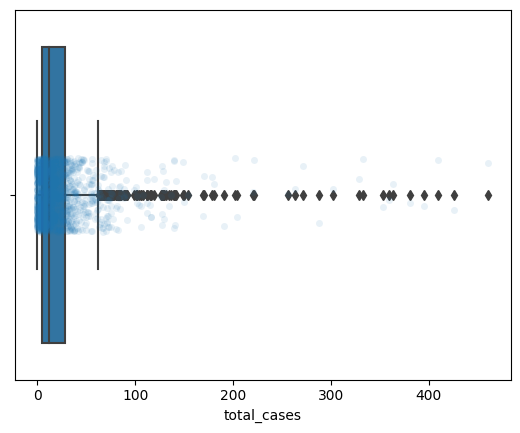

In [152]:
sns.boxplot(data=training_features_mag_homo, x='total_cases')
sns.stripplot(data=training_features_mag_homo, x='total_cases', alpha=0.1)

In [153]:
training_features_mag_homo.total_cases.describe()

count    1456.000000
mean       24.675137
std        43.596000
min         0.000000
25%         5.000000
50%        12.000000
75%        28.000000
max       461.000000
Name: total_cases, dtype: float64

In [154]:
training_features_mag_homo.total_cases.quantile(0.95)

81.25

95 % of cases are below 82.

In [155]:
"""bins = pd.cut(training_features_mag_homo.total_cases, 
              bins=np.arange(0, 461 + step, step), 
              include_lowest=True,
              right = False
              )
bins

amount = 6
bins.value_counts().head(amount) / examples, bins.value_counts().head(amount).sum() / examples"""

'bins = pd.cut(training_features_mag_homo.total_cases, \n              bins=np.arange(0, 461 + step, step), \n              include_lowest=True,\n              right = False\n              )\nbins\n\namount = 6\nbins.value_counts().head(amount) / examples, bins.value_counts().head(amount).sum() / examples'

#### Analysis of outliers

In [156]:
from scipy.stats import iqr
2 * iqr(training_features_mag_homo.total_cases)

46.0

Check outliers. Criterion is values higher than 2.0 IRQ

In [157]:
detect_outliers_IQR_df(training_features_mag_homo.select_dtypes(float), IQR_prop=2.0).sum()

ndvi_ne                                  195
ndvi_nw                                   54
ndvi_se                                   30
ndvi_sw                                   33
precipitation_amt_mm                      25
reanalysis_precip_amt_kg_per_m2           73
reanalysis_relative_humidity_percent      11
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_c                         10
station_avg_temp_c                        44
station_diur_temp_rng_c                   44
station_max_temp_c                        21
station_min_temp_c                        16
station_precip_mm                         78
total_cases                               86
reanalysis_max_air_temp_c                 10
reanalysis_min_air_temp_c                 10
reanalysis_avg_temp_c                     10
reanalysis_dew_point_temp_c               10
reanalysis_air_temp_c                     10
dtype: int64

Boxplots

In [158]:
#_=training_features_mag_homo.select_dtypes(float).plot(kind='box', whis=2.0, subplots=True, figsize=(20, 8))

In [159]:
training_features_mag_homo.head()

city  year  weekofyear   ndvi_ne   ndvi_nw   ndvi_se  \
week_start_date                                                         
1990-04-30          0  1990          18  0.122600  0.103725  0.198483   
1990-05-07          0  1990          19  0.169900  0.142175  0.162357   
1990-05-14          0  1990          20  0.032250  0.172967  0.157200   
1990-05-21          0  1990          21  0.128633  0.245067  0.227557   
1990-05-28          0  1990          22  0.196200  0.262200  0.251200   

                  ndvi_sw  precipitation_amt_mm  \
week_start_date                                   
1990-04-30       0.177617                 12.42   
1990-05-07       0.155486                 22.82   
1990-05-14       0.170843                 34.54   
1990-05-21       0.235886                 15.36   
1990-05-28       0.247340                  7.52   

                 reanalysis_precip_amt_kg_per_m2  \
week_start_date                                    
1990-04-30                                 32.00   
1990-05-07                                 17.94   
1990-05-14                                 26.10   
1990-05-21                                 13.90   
1990-05-28                                 12.20   

                 reanalysis_relative_humidity_percent  ...  \
week_start_date                                        ...   
1990-04-30                                  73.365714  ...   
1990-05-07                                  77.368571  ...   
1990-05-14                                  82.052857  ...   
1990-05-21                                  80.337143  ...   
1990-05-28                                  80.460000  ...   

                 station_diur_temp_rng_c  station_max_temp_c  \
week_start_date                                                
1990-04-30                      6.900000                29.4   
1990-05-07                      6.371429                31.7   
1990-05-14                      6.485714                32.2   
1990-05-21                      6.771429                33.3   
1990-05-28                      9.371429                35.0   

                 station_min_temp_c  station_precip_mm  total_cases  \
week_start_date                                                       
1990-04-30                     20.0               16.0          4.0   
1990-05-07                     22.2                8.6          5.0   
1990-05-14                     22.8               41.4          4.0   
1990-05-21                     23.3                4.0          3.0   
1990-05-28                     23.9                5.8          6.0   

                 reanalysis_max_air_temp_c  reanalysis_min_air_temp_c  \
week_start_date                                                         
1990-04-30                           26.65                      22.75   
1990-05-07                           27.75                      23.25   
1990-05-14                           27.35                      24.15   
1990-05-21                           28.25                      23.85   
1990-05-28                           28.75                      24.35   

                 reanalysis_avg_temp_c  reanalysis_dew_point_temp_c  \
week_start_date                                                       
1990-04-30                   24.592857                    19.264286   
1990-05-07                   25.292857                    20.801429   
1990-05-14                   25.728571                    22.284286   
1990-05-21                   26.078571                    22.160000   
1990-05-28                   26.514286                    22.671429   

                 reanalysis_air_temp_c  
week_start_date                         
1990-04-30                   24.422857  
1990-05-07                   25.061429  
1990-05-14                   25.631429  
1990-05-21                   25.837143  
1990-05-28                   26.368571  

[5 rows x 23 columns]

In [160]:
print(training_features_mag_homo.columns)

Index(['city', 'year', 'weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se',
       'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_c',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'total_cases',
       'reanalysis_max_air_temp_c', 'reanalysis_min_air_temp_c',
       'reanalysis_avg_temp_c', 'reanalysis_dew_point_temp_c',
       'reanalysis_air_temp_c'],
      dtype='object')


In [161]:
training_features_mag_homo[training_features_mag_homo.duplicated()]

Empty DataFrame
Columns: [city, year, weekofyear, ndvi_ne, ndvi_nw, ndvi_se, ndvi_sw, precipitation_amt_mm, reanalysis_precip_amt_kg_per_m2, reanalysis_relative_humidity_percent, reanalysis_specific_humidity_g_per_kg, reanalysis_tdtr_c, station_avg_temp_c, station_diur_temp_rng_c, station_max_temp_c, station_min_temp_c, station_precip_mm, total_cases, reanalysis_max_air_temp_c, reanalysis_min_air_temp_c, reanalysis_avg_temp_c, reanalysis_dew_point_temp_c, reanalysis_air_temp_c]
Index: []

[0 rows x 23 columns]

In [162]:
training_features_mag_homo.select_dtypes("float")

ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  precipitation_amt_mm  \
week_start_date                                                                 
1990-04-30       0.122600  0.103725  0.198483  0.177617                 12.42   
1990-05-07       0.169900  0.142175  0.162357  0.155486                 22.82   
1990-05-14       0.032250  0.172967  0.157200  0.170843                 34.54   
1990-05-21       0.128633  0.245067  0.227557  0.235886                 15.36   
1990-05-28       0.196200  0.262200  0.251200  0.247340                  7.52   
...                   ...       ...       ...       ...                   ...   
2010-05-28       0.342750  0.318900  0.256343  0.292514                 55.30   
2010-06-04       0.160157  0.160371  0.136043  0.225657                 86.47   
2010-06-11       0.247057  0.146057  0.250357  0.233714                 58.94   
2010-06-18       0.333914  0.245771  0.278886  0.325486                 59.67   
2010-06-25       0.298186  0.232971  0.274214  0.315757                 63.22   

                 reanalysis_precip_amt_kg_per_m2  \
week_start_date                                    
1990-04-30                                 32.00   
1990-05-07                                 17.94   
1990-05-14                                 26.10   
1990-05-21                                 13.90   
1990-05-28                                 12.20   
...                                          ...   
2010-05-28                                 45.00   
2010-06-04                                207.10   
2010-06-11                                 50.60   
2010-06-18                                 62.33   
2010-06-25                                 36.90   

                 reanalysis_relative_humidity_percent  \
week_start_date                                         
1990-04-30                                  73.365714   
1990-05-07                                  77.368571   
1990-05-14                                  82.052857   
1990-05-21                                  80.337143   
1990-05-28                                  80.460000   
...                                               ...   
2010-05-28                                  88.765714   
2010-06-04                                  91.600000   
2010-06-11                                  94.280000   
2010-06-18                                  94.660000   
2010-06-25                                  89.082857   

                 reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_c  \
week_start_date                                                             
1990-04-30                                   14.012857           2.628571   
1990-05-07                                   15.372857           2.371429   
1990-05-14                                   16.848571           2.300000   
1990-05-21                                   16.672857           2.428571   
1990-05-28                                   17.210000           3.014286   
...                                                ...                ...   
2010-05-28                                   18.485714           9.800000   
2010-06-04                                   18.070000           7.471429   
2010-06-11                                   17.008571           7.500000   
2010-06-18                                   16.815714           7.871429   
2010-06-25                                   17.355714          11.014286   

                 station_avg_temp_c  station_diur_temp_rng_c  \
week_start_date                                                
1990-04-30                25.442857                 6.900000   
1990-05-07                26.714286                 6.371429   
1990-05-14                26.714286                 6.485714   
1990-05-21                27.471429                 6.771429   
1990-05-28                28.942857                 9.371429   
...                             ...                      ...   
2010-05-28                28.63

ValueError: cannot reindex on an axis with duplicate labels

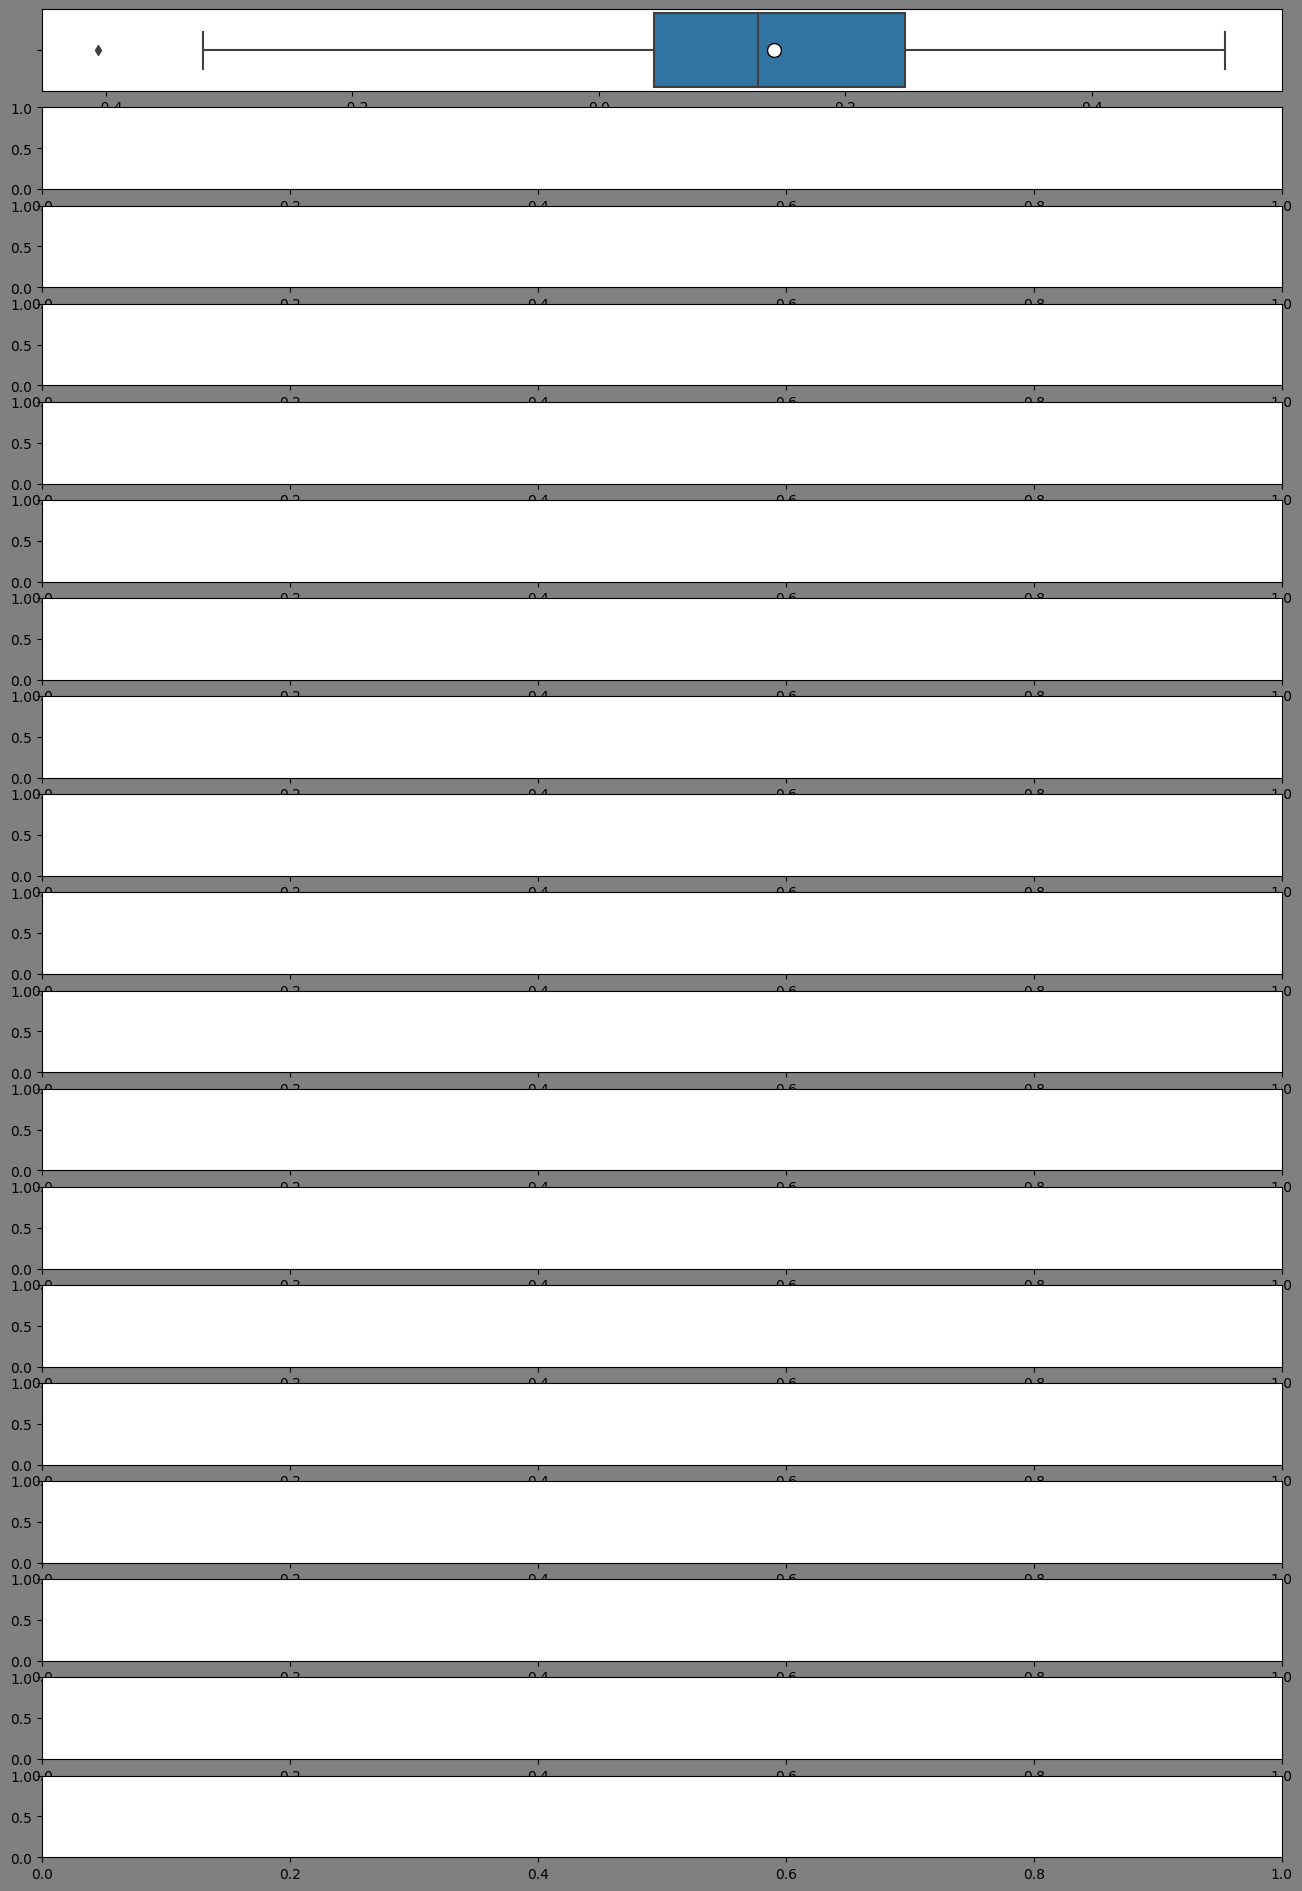

In [164]:
multi_plot_numerical(training_features_mag_homo, 
                     which_plot="boxplot", 
                     IQR_prop=2.0, 
                     bins=None, 
                     stat="probability", 
                     axes_fc="lightgray", 
                     fig_fc="gray")

Histograms

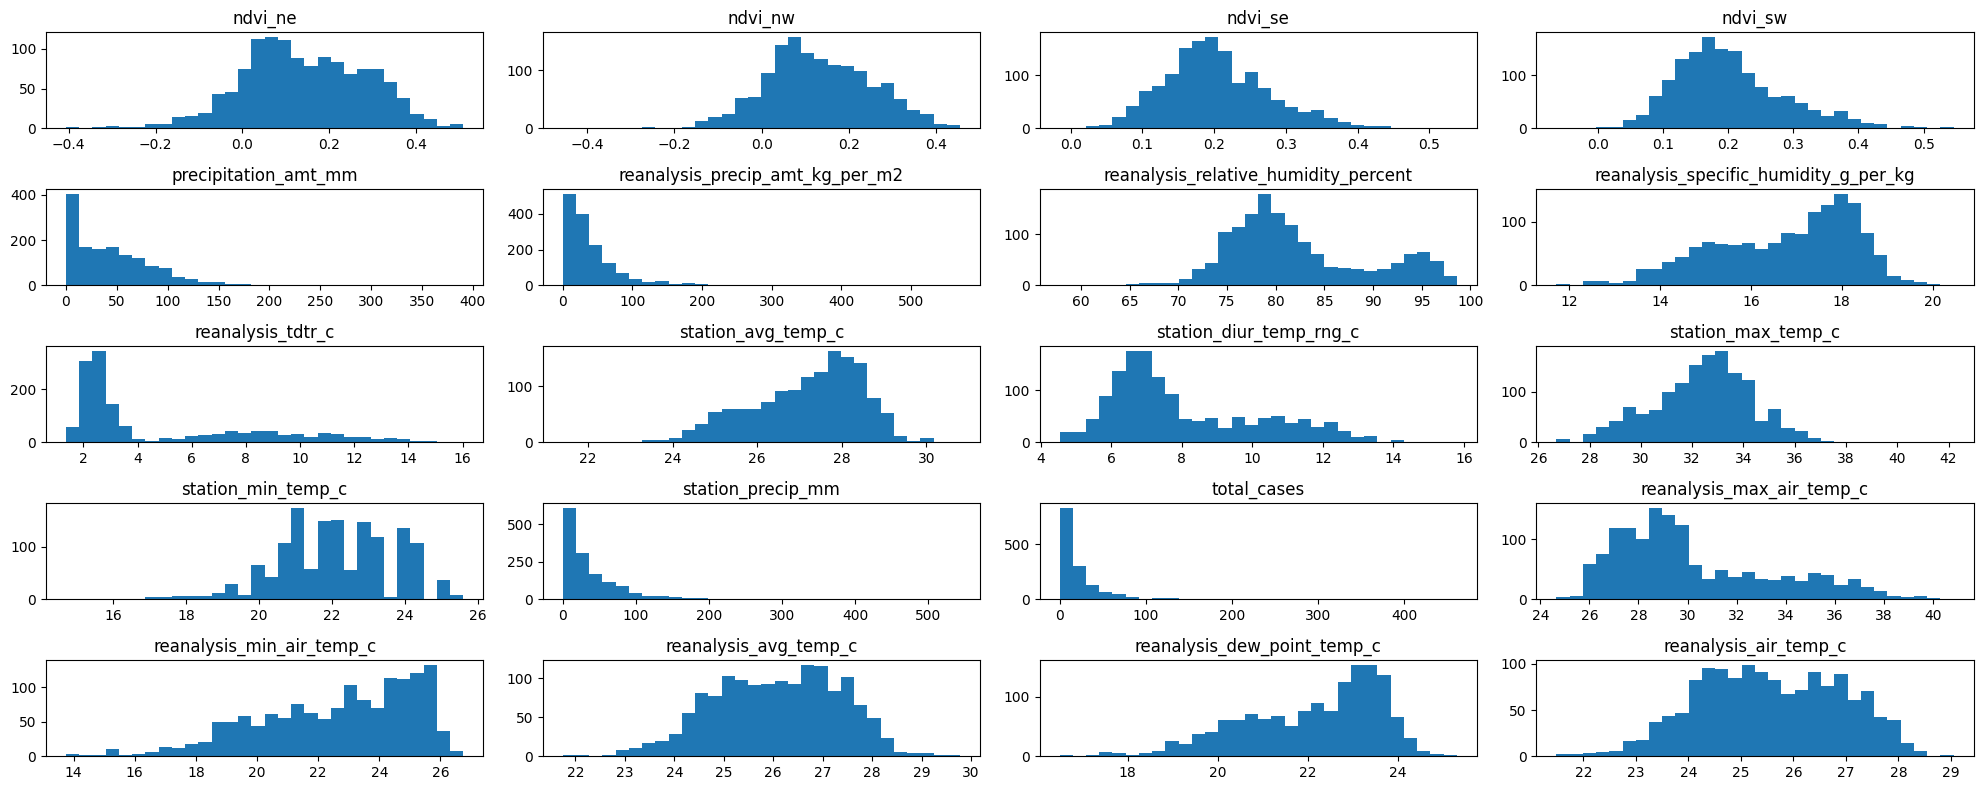

In [165]:
training_features_mag_homo.select_dtypes(float).hist(grid=False, figsize=(20, 8), bins=30)
plt.tight_layout()

In [ ]:
#multi_boxplot_hist(training_features_mag_homo, figsize=(10, 30))

### Outlier correction

Correct outliers: upper outliers get value of upper whisker. Lower outliers are imputed with low whisker. However, there are some features that shouldn't have negative values, shuch as precipitation_amt_mm, where a negative value does not have any reasonable meaning. In these cases, value of 0 is imputed instead. 

Other features are limited to a certain range of values like *reanalysis_relative_humidity_percent* with lower and upper bound of 0 and 100, respectevely.

In [173]:
# Don't treat 'total_cases'
lower_bounded_columns = ['precipitation_amt_mm', 
                         'reanalysis_precip_amt_kg_per_m2',
                         'reanalysis_specific_humidity_g_per_kg',
                         'reanalysis_tdtr_c',
                         'station_diur_temp_rng_c',
                         'station_precip_mm'
                         ]

bounded_columns = ['reanalysis_relative_humidity_percent']

non_treated_columns = ['total_cases']

all_columns = training_features_mag_homo.select_dtypes(float).columns
unbounded_cols = [c for c in all_columns if c not in (lower_bounded_columns + bounded_columns + non_treated_columns)]
unbounded_cols

['ndvi_ne',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'station_avg_temp_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'reanalysis_max_air_temp_c',
 'reanalysis_min_air_temp_c',
 'reanalysis_avg_temp_c',
 'reanalysis_dew_point_temp_c',
 'reanalysis_air_temp_c']

<Axes: xlabel='ndvi_nw'>

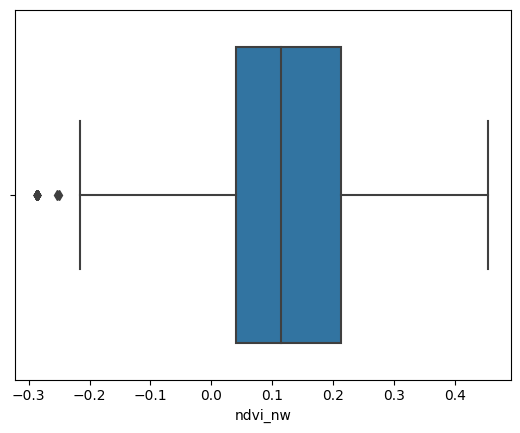

In [177]:
sns.boxplot(data=training_features_mag_homo, x="ndvi_nw")

Unbounded features

In [171]:
training_features_mag_homo.loc[:, unbounded_cols] = correct_outliers_to_IQR(training_features_mag_homo[unbounded_cols], 
                                                                            IQR_prop=2.0)

column | bot_value | top_value | IQR | Q3
ndvi_ne -0.36211665 0.655549975 0.203533325 0.248483325
ndvi_nw -0.2855499975 0.551366665 0.16738333249999998 0.2166
ndvi_se -0.032429225000000034 0.43636252500000006 0.09375835000000002 0.24884582500000002
ndvi_sw -0.06133812499999999 0.452529 0.102773425 0.24698215
station_avg_temp_c 22.585714285800005 31.871428571299994 1.8571428570999977 28.1571428571
station_max_temp_c 25.500000000000007 39.49999999999999 2.799999999999997 33.9
station_min_temp_c 16.700000000000003 27.7 2.1999999999999993 23.3
reanalysis_max_air_temp_c 18.850000000000023 41.35000000000002 4.5 32.35000000000002
reanalysis_min_air_temp_c 12.75 32.75 4.0 24.75
reanalysis_avg_temp_c 21.207142857000065 30.957142857000008 1.9499999999999886 27.05714285700003
reanalysis_dew_point_temp_c 16.286785715250033 27.99214285649998 2.3410714282499896 23.310000000000002
reanalysis_air_temp_c 20.15964285875009 31.03285714124995 2.174642856499972 26.683571428250005


lower-bound features

In [176]:
training_features_mag_homo.loc[:, lower_bounded_columns] = correct_outliers_to_IQR(training_features_mag_homo[lower_bounded_columns], IQR_prop=3.0, low_bounded=True)

column | bot_value | top_value | IQR | Q3
precipitation_amt_mm 0.0 251.54000000000002 60.435 70.235
reanalysis_precip_amt_kg_per_m2 0.0 169.635 39.145 52.2
reanalysis_specific_humidity_g_per_kg 8.293928571325008 25.24142857152499 2.4210714285999977 17.978214285725
reanalysis_tdtr_c 0.0 23.51428571429 5.29642857143 7.625
station_diur_temp_rng_c 0.0 18.723809523810004 3.052380952380001 9.56666666667
station_precip_mm 0.0 189.50000000000003 45.2 53.9


bounded features

In [178]:
training_features_mag_homo.loc[:, bounded_columns] = correct_outliers_to_IQR(training_features_mag_homo[bounded_columns], IQR_prop=3.0, full_bounded=True)

column | bot_value | top_value | IQR | Q3
reanalysis_relative_humidity_percent 49.63500000014997 100.0 9.180714285675009 86.35785714285001


In [179]:
detect_outliers_IQR_df(training_features_mag_homo.select_dtypes(float)).sum()

ndvi_ne                                  195
ndvi_nw                                   56
ndvi_se                                   44
ndvi_sw                                   53
precipitation_amt_mm                      24
reanalysis_precip_amt_kg_per_m2           87
reanalysis_relative_humidity_percent      12
reanalysis_specific_humidity_g_per_kg     11
reanalysis_tdtr_c                          2
station_avg_temp_c                        45
station_diur_temp_rng_c                   48
station_max_temp_c                        24
station_min_temp_c                        24
station_precip_mm                         80
total_cases                              124
reanalysis_max_air_temp_c                 17
reanalysis_min_air_temp_c                 15
reanalysis_avg_temp_c                     12
reanalysis_dew_point_temp_c               15
reanalysis_air_temp_c                     10
dtype: int64

In [180]:
training_features_mag_homo.select_dtypes(float).describe().T

count       mean        std  \
ndvi_ne                                1456.0   0.075115   0.215620   
ndvi_nw                                1456.0   0.115825   0.140443   
ndvi_se                                1456.0   0.200061   0.078240   
ndvi_sw                                1456.0   0.198041   0.088353   
precipitation_amt_mm                   1456.0  45.136751  42.384436   
reanalysis_precip_amt_kg_per_m2        1456.0  38.629523  36.920351   
reanalysis_relative_humidity_percent   1456.0  81.938560   7.618928   
reanalysis_specific_humidity_g_per_kg  1456.0  16.688374   1.688370   
reanalysis_tdtr_c                      1456.0   4.870075   3.557382   
station_avg_temp_c                     1456.0  27.050744   1.489784   
station_diur_temp_rng_c                1456.0   7.821312   2.501954   
station_max_temp_c                     1456.0  32.355082   2.099982   
station_min_temp_c                     1456.0  22.051786   1.646881   
station_precip_mm                      1456.0  37.529121  41.311732   
total_cases                            1456.0  24.675137  43.596000   
reanalysis_max_air_temp_c              1456.0  30.198626   3.358872   
reanalysis_min_air_temp_c              1456.0  22.501717   2.682156   
reanalysis_avg_temp_c                  1456.0  26.042141   1.320138   
reanalysis_dew_point_temp_c            1456.0  22.056456   1.596413   
reanalysis_air_temp_c                  1456.0  25.514818   1.428948   

                                             min        25%        50%  \
ndvi_ne                                -0.362117  -0.000788   0.104114   
ndvi_nw                                -0.285550   0.040175   0.114633   
ndvi_se                                -0.032429   0.152580   0.195207   
ndvi_sw                                -0.061338   0.141007   0.187464   
precipitation_amt_mm                    0.000000   9.115000  37.660000   
reanalysis_precip_amt_kg_per_m2         0.000000  12.800000  27.080000   
reanalysis_relative_humidity_percent   49.635000  77.090357  80.255714   
reanalysis_specific_humidity_g_per_kg   8.293929  15.511429  17.065000   
reanalysis_tdtr_c                       0.000000   2.325000   2.835714   
station_avg_temp_c                     22.585714  26.200000  27.385714   
station_diur_temp_rng_c                 0.000000   6.439286   7.242857   
station_max_temp_c                     25.500000  31.100000  32.800000   
station_min_temp_c                     16.700000  21.000000  22.200000   
station_precip_mm                       0.000000   8.175000  23.150000   
total_cases                             0.000000   5.000000  12.000000   
reanalysis_max_air_temp_c              18.850000  27.750000  29.250000   
reanalysis_min_air_temp_c              12.750000  20.650000  23.050000   
reanalysis_avg_temp_c                  21.207143  25.092857  26.117857   
reanalysis_dew_point_temp_c            16.286786  20.921071  22.475714   
reanalysis_air_temp_c                  20.159643  24.490000  25.477857   

                                             75%         max  
ndvi_ne                                 0.229292    0.508357  
ndvi_nw                                 0.212325    0.454429  
ndvi_se                                 0.247021    0.436363  
ndvi_sw                                 0.246082    0.452529  
precipitation_amt_mm                   70.047500  251.540000  
reanalysis_precip_amt_kg_per_m2        52.042500  169.635000  
reanalysis_relative_humidity_percent   86.041429   98.610000  
reanalysis_specific_humidity_g_per_kg  17.974643   20.461429  
reanalysis_tdtr_c                       7.553571   16.028571  
station_avg_temp_c                     28.128571   30.800000  
station_diur_temp_rng_c                 9.500000   15.800000  
station_max_temp_c                     33.900000   39.500000  
station_min_temp_c                     23.300000   25.600000  
station_precip_mm                      53.600000  189.500000  
total_cases                            28.000000

#### Impute null values

Imputation: median or KNNImputer

In [181]:
training_features_mag_homo.describe().T

count         mean        std  \
city                                   1456.0     0.357143   0.479322   
year                                   1456.0  2001.031593   5.408314   
weekofyear                             1456.0    26.503434  15.019437   
ndvi_ne                                1456.0     0.075115   0.215620   
ndvi_nw                                1456.0     0.115825   0.140443   
ndvi_se                                1456.0     0.200061   0.078240   
ndvi_sw                                1456.0     0.198041   0.088353   
precipitation_amt_mm                   1456.0    45.136751  42.384436   
reanalysis_precip_amt_kg_per_m2        1456.0    38.629523  36.920351   
reanalysis_relative_humidity_percent   1456.0    81.938560   7.618928   
reanalysis_specific_humidity_g_per_kg  1456.0    16.688374   1.688370   
reanalysis_tdtr_c                      1456.0     4.870075   3.557382   
station_avg_temp_c                     1456.0    27.050744   1.489784   
station_diur_temp_rng_c                1456.0     7.821312   2.501954   
station_max_temp_c                     1456.0    32.355082   2.099982   
station_min_temp_c                     1456.0    22.051786   1.646881   
station_precip_mm                      1456.0    37.529121  41.311732   
total_cases                            1456.0    24.675137  43.596000   
reanalysis_max_air_temp_c              1456.0    30.198626   3.358872   
reanalysis_min_air_temp_c              1456.0    22.501717   2.682156   
reanalysis_avg_temp_c                  1456.0    26.042141   1.320138   
reanalysis_dew_point_temp_c            1456.0    22.056456   1.596413   
reanalysis_air_temp_c                  1456.0    25.514818   1.428948   

                                               min          25%          50%  \
city                                      0.000000     0.000000     0.000000   
year                                   1990.000000  1997.000000  2002.000000   
weekofyear                                1.000000    13.750000    26.500000   
ndvi_ne                                  -0.362117    -0.000788     0.104114   
ndvi_nw                                  -0.285550     0.040175     0.114633   
ndvi_se                                  -0.032429     0.152580     0.195207   
ndvi_sw                                  -0.061338     0.141007     0.187464   
precipitation_amt_mm                      0.000000     9.115000    37.660000   
reanalysis_precip_amt_kg_per_m2           0.000000    12.800000    27.080000   
reanalysis_relative_humidity_percent     49.635000    77.090357    80.255714   
reanalysis_specific_humidity_g_per_kg     8.293929    15.511429    17.065000   
reanalysis_tdtr_c                         0.000000     2.325000     2.835714   
station_avg_temp_c                       22.585714    26.200000    27.385714   
station_diur_temp_rng_c                   0.000000     6.439286     7.242857   
station_max_temp_c                       25.500000    31.100000    32.800000   
station_min_temp_c                       16.700000    21.000000    22.200000   
station_precip_mm                         0.000000     8.175000    23.150000   
total_cases                               0.000000     5.000000    12.000000   
reanalysis_max_air_temp_c                18.850000    27.750000    29.250000   
reanalysis_min_air_temp_c                12.750000    20.650000    23.050000   
reanalysis_avg_temp_c                    21.207143    25.092857    26.117857   
reanalysis_dew_point_temp_c              16.286786    20.921071    22.475714   
reanalysis_air_temp_c                    20.159643    24.490000    25.477857   

                                               75%          max  
city                                      1.000000     1.000000  
year                                   2005.000000  2010.000000  
weekofyear                               39.250000    53.000000  
ndvi_ne                                   0.229292     0.508357  
ndvi_nw                             

Imputation through mean or median values is appropriate if there are few missing values. Otherwise, KNNImputer should be used, but in this case it can impute negative values which are not suited for the kind of variable we are dealing with. For that reason, we use method interpolate() to impute missing values.

Imputation with statistic

In [182]:
#cols_with_nulls = training_features.columns[training_features.isnull().sum() != 0]
#training_features.loc[:, cols_with_nulls] = impute_nulls(training_features, method='median', columns=cols_with_nulls)

Imputation with KNNImputer

In [183]:
from sklearn.impute import KNNImputer
knn_imputer = KNNImputer()

training_features_mag_homo_null_imputed = training_features_mag_homo.copy()
training_features_mag_homo_null_imputed.loc[:, training_features_mag_homo_null_imputed.select_dtypes(float).columns] = knn_imputer.fit_transform(training_features_mag_homo_null_imputed.select_dtypes(float))

Imputation with interpolation() method

In [184]:
"""training_features_mag_homo_null_imputed = training_features_mag_homo.copy()
training_features_mag_homo_null_imputed.interpolate(method='pad', inplace=True)"""

"training_features_mag_homo_null_imputed = training_features_mag_homo.copy()\ntraining_features_mag_homo_null_imputed.interpolate(method='pad', inplace=True)"

In [185]:
training_features_mag_homo_null_imputed.describe().T

count         mean        std  \
city                                   1456.0     0.357143   0.479322   
year                                   1456.0  2001.031593   5.408314   
weekofyear                             1456.0    26.503434  15.019437   
ndvi_ne                                1456.0     0.075115   0.215620   
ndvi_nw                                1456.0     0.115825   0.140443   
ndvi_se                                1456.0     0.200061   0.078240   
ndvi_sw                                1456.0     0.198041   0.088353   
precipitation_amt_mm                   1456.0    45.136751  42.384436   
reanalysis_precip_amt_kg_per_m2        1456.0    38.629523  36.920351   
reanalysis_relative_humidity_percent   1456.0    81.938560   7.618928   
reanalysis_specific_humidity_g_per_kg  1456.0    16.688374   1.688370   
reanalysis_tdtr_c                      1456.0     4.870075   3.557382   
station_avg_temp_c                     1456.0    27.050744   1.489784   
station_diur_temp_rng_c                1456.0     7.821312   2.501954   
station_max_temp_c                     1456.0    32.355082   2.099982   
station_min_temp_c                     1456.0    22.051786   1.646881   
station_precip_mm                      1456.0    37.529121  41.311732   
total_cases                            1456.0    24.675137  43.596000   
reanalysis_max_air_temp_c              1456.0    30.198626   3.358872   
reanalysis_min_air_temp_c              1456.0    22.501717   2.682156   
reanalysis_avg_temp_c                  1456.0    26.042141   1.320138   
reanalysis_dew_point_temp_c            1456.0    22.056456   1.596413   
reanalysis_air_temp_c                  1456.0    25.514818   1.428948   

                                               min          25%          50%  \
city                                      0.000000     0.000000     0.000000   
year                                   1990.000000  1997.000000  2002.000000   
weekofyear                                1.000000    13.750000    26.500000   
ndvi_ne                                  -0.362117    -0.000788     0.104114   
ndvi_nw                                  -0.285550     0.040175     0.114633   
ndvi_se                                  -0.032429     0.152580     0.195207   
ndvi_sw                                  -0.061338     0.141007     0.187464   
precipitation_amt_mm                      0.000000     9.115000    37.660000   
reanalysis_precip_amt_kg_per_m2           0.000000    12.800000    27.080000   
reanalysis_relative_humidity_percent     49.635000    77.090357    80.255714   
reanalysis_specific_humidity_g_per_kg     8.293929    15.511429    17.065000   
reanalysis_tdtr_c                         0.000000     2.325000     2.835714   
station_avg_temp_c                       22.585714    26.200000    27.385714   
station_diur_temp_rng_c                   0.000000     6.439286     7.242857   
station_max_temp_c                       25.500000    31.100000    32.800000   
station_min_temp_c                       16.700000    21.000000    22.200000   
station_precip_mm                         0.000000     8.175000    23.150000   
total_cases                               0.000000     5.000000    12.000000   
reanalysis_max_air_temp_c                18.850000    27.750000    29.250000   
reanalysis_min_air_temp_c                12.750000    20.650000    23.050000   
reanalysis_avg_temp_c                    21.207143    25.092857    26.117857   
reanalysis_dew_point_temp_c              16.286786    20.921071    22.475714   
reanalysis_air_temp_c                    20.159643    24.490000    25.477857   

                                               75%          max  
city                                      1.000000     1.000000  
year                                   2005.000000  2010.000000  
weekofyear                               39.250000    53.000000  
ndvi_ne                                   0.229292     0.508357  
ndvi_nw                             

In [186]:
null_summary(training_features_mag_homo_null_imputed)

Number null  Perc null
city                                             0        0.0
year                                             0        0.0
weekofyear                                       0        0.0
ndvi_ne                                          0        0.0
ndvi_nw                                          0        0.0
ndvi_se                                          0        0.0
ndvi_sw                                          0        0.0
precipitation_amt_mm                             0        0.0
reanalysis_precip_amt_kg_per_m2                  0        0.0
reanalysis_relative_humidity_percent             0        0.0
reanalysis_specific_humidity_g_per_kg            0        0.0
reanalysis_tdtr_c                                0        0.0
station_avg_temp_c                               0        0.0
station_diur_temp_rng_c                          0        0.0
station_max_temp_c                               0        0.0
station_min_temp_c                               0        0.0
station_precip_mm                                0        0.0
total_cases                                      0        0.0
reanalysis_max_air_temp_c                        0        0.0
reanalysis_min_air_temp_c                        0        0.0
reanalysis_avg_temp_c                            0        0.0
reanalysis_dew_point_temp_c                      0        0.0
reanalysis_air_temp_c                            0        0.0

#### Frequencies of categorical features

In [187]:
#@title Specify Show Frequencies.  { display-mode: "form" }

column = 'year'  # @param ['year', 'weekofyear']
training_features_mag_homo.value_counts(['city', column], sort=False)


city  year
0     1990    35
      1991    52
      1992    52
      1993    52
      1994    52
      1995    52
      1996    52
      1997    52
      1998    52
      1999    52
      2000    52
      2001    52
      2002    52
      2003    52
      2004    52
      2005    52
      2006    52
      2007    52
      2008    17
1     2000    26
      2001    52
      2002    52
      2003    52
      2004    52
      2005    52
      2006    52
      2007    52
      2008    52
      2009    52
      2010    26
Name: count, dtype: int64

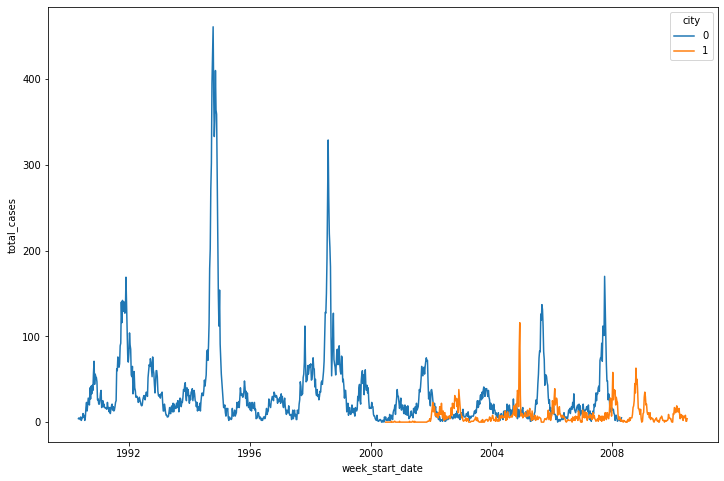

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(12, 8))
sns.lineplot(data=training_features_mag_homo_null_imputed.reset_index(), x='week_start_date', y='total_cases', hue='city', ax=axes)

There are years that are oversampled w.t.r. to others. Let's check why

In [ ]:
training_features_mag_homo_null_imputed.index[training_features_mag_homo_null_imputed.index.year == 1990].value_counts().index.sort_values()

DatetimeIndex(['1990-04-30', '1990-05-07', '1990-05-14', '1990-05-21',
               '1990-05-28', '1990-06-04', '1990-06-11', '1990-06-18',
               '1990-06-25', '1990-07-02', '1990-07-09', '1990-07-16',
               '1990-07-23', '1990-07-30', '1990-08-06', '1990-08-13',
               '1990-08-20', '1990-08-27', '1990-09-03', '1990-09-10',
               '1990-09-17', '1990-09-24', '1990-10-01', '1990-10-08',
               '1990-10-15', '1990-10-22', '1990-10-29', '1990-11-05',
               '1990-11-12', '1990-11-19', '1990-11-26', '1990-12-03',
               '1990-12-10', '1990-12-17', '1990-12-24'],
              dtype='datetime64[ns]', freq=None)

First record was registered on the 30th of April.

In [ ]:
training_features_mag_homo_null_imputed[(training_features_mag_homo_null_imputed.index.year == 2000) & (training_features_mag_homo_null_imputed.city == 1)].index.value_counts()

2000-07-08    1
2000-12-23    1
2000-07-15    1
2000-11-04    1
2000-09-30    1
2000-08-26    1
2000-07-22    1
2000-09-09    1
2000-08-05    1
2000-12-09    1
2000-09-23    1
2000-11-18    1
2000-10-14    1
2000-11-25    1
2000-08-12    1
2000-07-29    1
2000-12-02    1
2000-09-02    1
2000-10-28    1
2000-08-19    1
2000-11-11    1
2000-10-07    1
2000-12-16    1
2000-07-01    1
2000-09-16    1
2000-10-21    1
Name: week_start_date, dtype: int64

Last record was registered on the 25h of June.

In [ ]:
training_features_mag_homo_null_imputed[(training_features_mag_homo_null_imputed.index.year == 2010) & (training_features_mag_homo_null_imputed.city == 1)].index.value_counts()

2010-01-22    1
2010-03-12    1
2010-05-07    1
2010-01-29    1
2010-04-30    1
2010-04-16    1
2010-02-05    1
2010-03-26    1
2010-03-05    1
2010-04-09    1
2010-06-25    1
2010-02-12    1
2010-06-18    1
2010-02-19    1
2010-05-28    1
2010-04-02    1
2010-03-19    1
2010-04-23    1
2010-02-26    1
2010-05-14    1
2010-01-08    1
2010-06-11    1
2010-01-15    1
2010-05-21    1
2010-06-04    1
2010-01-01    1
Name: week_start_date, dtype: int64

In [ ]:
training_features_mag_homo_null_imputed[(training_features_mag_homo_null_imputed.index.year == 1991) & (training_features_mag_homo_null_imputed.city == 0)].index.value_counts()

1991-04-23    1
1991-03-26    1
1991-09-03    1
1991-09-10    1
1991-06-25    1
1991-01-01    1
1991-04-09    1
1991-05-07    1
1991-10-22    1
1991-08-06    1
1991-11-12    1
1991-01-08    1
1991-12-03    1
1991-09-17    1
1991-08-13    1
1991-12-24    1
1991-07-02    1
1991-04-16    1
1991-10-29    1
1991-02-26    1
1991-02-19    1
1991-05-28    1
1991-11-19    1
1991-09-24    1
1991-04-02    1
1991-12-17    1
1991-05-14    1
1991-05-21    1
1991-08-27    1
1991-11-05    1
1991-08-20    1
1991-11-26    1
1991-06-04    1
1991-07-09    1
1991-03-19    1
1991-03-12    1
1991-01-22    1
1991-04-30    1
1991-10-15    1
1991-06-11    1
1991-07-30    1
1991-03-05    1
1991-06-18    1
1991-07-16    1
1991-10-08    1
1991-07-23    1
1991-10-01    1
1991-01-29    1
1991-02-12    1
1991-12-10    1
1991-02-05    1
1991-01-15    1
Name: week_start_date, dtype: int64

In [ ]:
training_features_mag_homo_null_imputed[(training_features_mag_homo_null_imputed.index.year == 2001) & (training_features_mag_homo_null_imputed.city == 0)].index.value_counts()

2001-03-26    1
2001-11-05    1
2001-02-19    1
2001-09-03    1
2001-07-16    1
2001-03-12    1
2001-04-16    1
2001-09-24    1
2001-08-27    1
2001-12-17    1
2001-05-07    1
2001-01-01    1
2001-04-30    1
2001-01-22    1
2001-08-13    1
2001-12-03    1
2001-12-10    1
2001-05-28    1
2001-08-06    1
2001-11-26    1
2001-04-09    1
2001-11-19    1
2001-10-08    1
2001-09-17    1
2001-07-23    1
2001-06-25    1
2001-05-21    1
2001-09-10    1
2001-02-26    1
2001-01-15    1
2001-07-30    1
2001-07-09    1
2001-10-29    1
2001-08-20    1
2001-07-02    1
2001-10-22    1
2001-12-24    1
2001-03-05    1
2001-10-15    1
2001-04-02    1
2001-06-04    1
2001-06-18    1
2001-03-19    1
2001-10-01    1
2001-04-23    1
2001-06-11    1
2001-05-14    1
2001-01-08    1
2001-02-12    1
2001-01-29    1
2001-02-05    1
2001-11-12    1
Name: week_start_date, dtype: int64

It seems two measures were taken per week for year 2001. On the contrary, one measure was taken for 1990.

In [ ]:
training_features_mag_homo_null_imputed[(training_features_mag_homo_null_imputed.index.year == 1990) & (training_features_mag_homo_null_imputed.city == 0)].index.value_counts()

1990-09-10    1
1990-11-19    1
1990-05-28    1
1990-06-25    1
1990-09-03    1
1990-05-21    1
1990-09-24    1
1990-11-12    1
1990-07-09    1
1990-07-23    1
1990-05-14    1
1990-10-15    1
1990-07-30    1
1990-12-24    1
1990-05-07    1
1990-08-20    1
1990-12-17    1
1990-11-26    1
1990-10-29    1
1990-08-06    1
1990-04-30    1
1990-11-05    1
1990-10-01    1
1990-07-16    1
1990-06-18    1
1990-12-10    1
1990-08-27    1
1990-12-03    1
1990-06-11    1
1990-09-17    1
1990-10-22    1
1990-07-02    1
1990-06-04    1
1990-10-08    1
1990-08-13    1
Name: week_start_date, dtype: int64

1. **City**: More examples of San Juan than Iq.
2. **Year**: The number of samples either remain constant along the years or increase, except from last three years, when they decrease w.r.t. previous years: 2008, 2009 and 2010.
3. **Weekofyear**: The last two weeks of year contain less values.

### Linear correlations (Spearman coefficient)

In [ ]:
training_features_mag_homo_null_imputed_float = training_features_mag_homo_null_imputed.select_dtypes(float).copy()
training_features_mag_homo_null_imputed_float.head()

ndvi_ne  ...  reanalysis_air_temp_c
week_start_date            ...                       
1990-04-30       0.122600  ...              24.422857
1990-05-07       0.169900  ...              25.061429
1990-05-14       0.032250  ...              25.631429
1990-05-21       0.128633  ...              25.837143
1990-05-28       0.196200  ...              26.368571

[5 rows x 20 columns]

In [ ]:
columns_float = training_features_mag_homo_null_imputed_float.columns
columns_float, len(columns_float)

(Index(['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm',
        'reanalysis_precip_amt_kg_per_m2',
        'reanalysis_relative_humidity_percent',
        'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_c',
        'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
        'station_min_temp_c', 'station_precip_mm', 'total_cases',
        'reanalysis_max_air_temp_c', 'reanalysis_min_air_temp_c',
        'reanalysis_avg_temp_c', 'reanalysis_dew_point_temp_c',
        'reanalysis_air_temp_c'],
       dtype='object'), 20)

In [ ]:
"""from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

seismic = cm.get_cmap('seismic', 256)
newcolors = seismic(np.linspace(0, 1, 256))
#pink = np.array([248/256, 24/256, 148/256, 1])
#newcolors[:25, :] = pink
newcmp = ListedColormap(newcolors)"""

"from matplotlib import cm\nfrom matplotlib.colors import ListedColormap, LinearSegmentedColormap\n\nseismic = cm.get_cmap('seismic', 256)\nnewcolors = seismic(np.linspace(0, 1, 256))\n#pink = np.array([248/256, 24/256, 148/256, 1])\n#newcolors[:25, :] = pink\nnewcmp = ListedColormap(newcolors)"

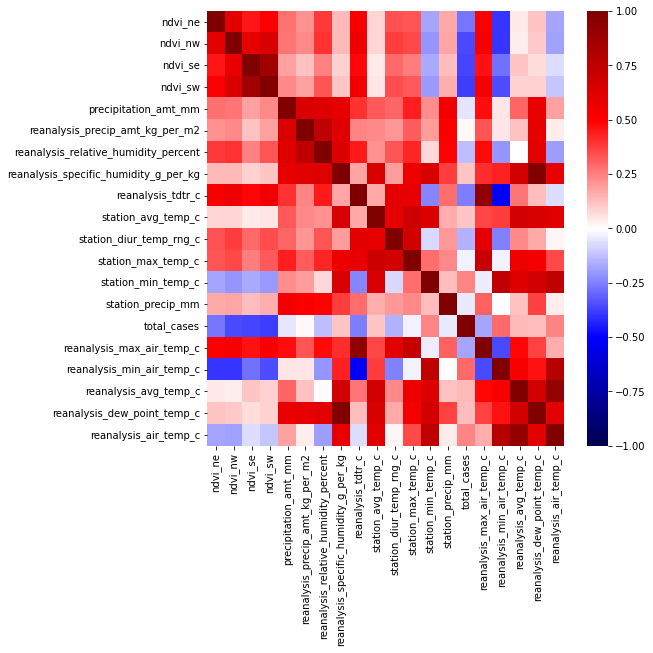

In [ ]:
_, axes2 = plt.subplots(1, 1, figsize=(8, 8))

corr_limit = 0
x = training_features_mag_homo_null_imputed.select_dtypes(float).corr()
y = x.where((x >= corr_limit) | (x <= - corr_limit), 0.0)

#heatmap1 = sns.heatmap(x, ax=axes2, cmap='seismic', vmin=-1, vmax=1)
heatmap2 = sns.heatmap(y, ax=axes2, cmap='seismic', vmin=-1.0, vmax=1.0)

Some features shows high pearson coefficient, but that doesn't necessarily mean a functional linear relationship between variables, because it might be caused by non-linear correlations.

Scatter plots individualized for selected column

In [ ]:
#column_pairs_not_repeat = [(col1, col2) for i, col1 in enumerate(columns_float) for col2 in columns_float[i + 1:]]
column_pairs_not_repeat = {col: [col1 for col1 in columns_float if col1 != col] for i, col in enumerate(columns_float[:-1])}

In [ ]:
import ipywidgets as widgets

column_picker = widgets.Dropdown(options=columns_float, value='ndvi_ne')
column_picker

Dropdown(options=('ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_precip_amt_k…

In [ ]:
training_features_mag_homo_null_imputed_float.columns

Index(['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_c',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'total_cases',
       'reanalysis_max_air_temp_c', 'reanalysis_min_air_temp_c',
       'reanalysis_avg_temp_c', 'reanalysis_dew_point_temp_c',
       'reanalysis_air_temp_c'],
      dtype='object')

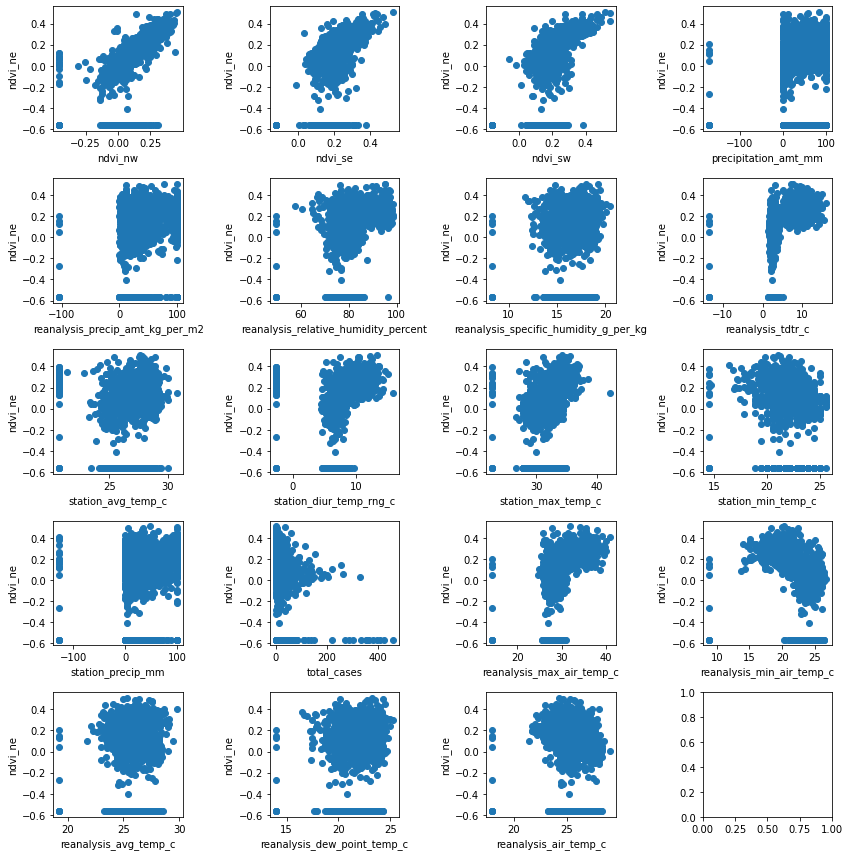

In [ ]:
plot_pair(training_features_mag_homo_null_imputed, column_pairs_not_repeat, column_picker.value)

1. ndvi_sw: certain correlation with other ndvi_xx features and and reanalysis_min_air_temp_c
1. precipitation_amt_mm: hard to see any obvious correlation.
1. reanalysis_precip_amt_kg_per_m2: possible non-linear correlations.
1. reanalysis_relative_humidity_percent: correlation with some features, but it also presents clusters. reanalysis_dew_point_temp_c shows evident linear correlations and reanalysis_precip_amt_kg_per_m2
5. reanalysis_tdtr_c: good correlation with reanalysis_max_air_temp_c, reanalysis_min_air_temp_c and station_diur_temp_rng_c
6. reanalysis_max/min_air_temp_c: good correlation with diurnal and avg features.
7. reanalysis_avg_temp_c: good correlation with features related to temperature and specific reanalysis_specific_humidity_g_per_kg.
8. reanalysis_air_temp_c: same conclusions as in reanalysis_avg_temp_c.
9. total_cases: it shows little evidence of correlation with other variables.

In summary, there are pairs of features which measure the same event through different methods. We should either discard redundant features from one of the two methods or selectively choose the best features from both methods.

## EDA 2_Analysis of extreme cases from target

In [ ]:
q95_total_cases = int(training_features_mag_homo.total_cases.quantile(0.95))

training_features_mag_homo_extremeTarget = \
  training_features_mag_homo.loc[training_features_mag_homo.total_cases >= q95_total_cases, :]

In [ ]:
training_features_mag_homo_extremeTarget.head(2)

city  year  ...  reanalysis_dew_point_temp_c  reanalysis_air_temp_c
week_start_date              ...                                                    
1991-09-17          0  1991  ...                    23.751429              27.377143
1991-09-24          0  1991  ...                    23.440000              26.910000

[2 rows x 23 columns]

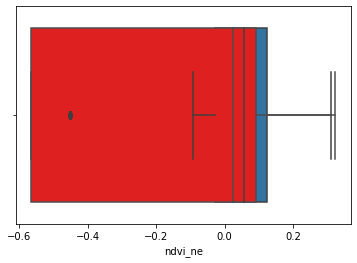

In [ ]:
sns.boxplot(data=training_features_mag_homo_extremeTarget, x='ndvi_nw')

sns.boxplot(data=training_features_mag_homo_extremeTarget.loc[training_features_mag_homo_extremeTarget.total_cases > 10], x='ndvi_ne', color='red')

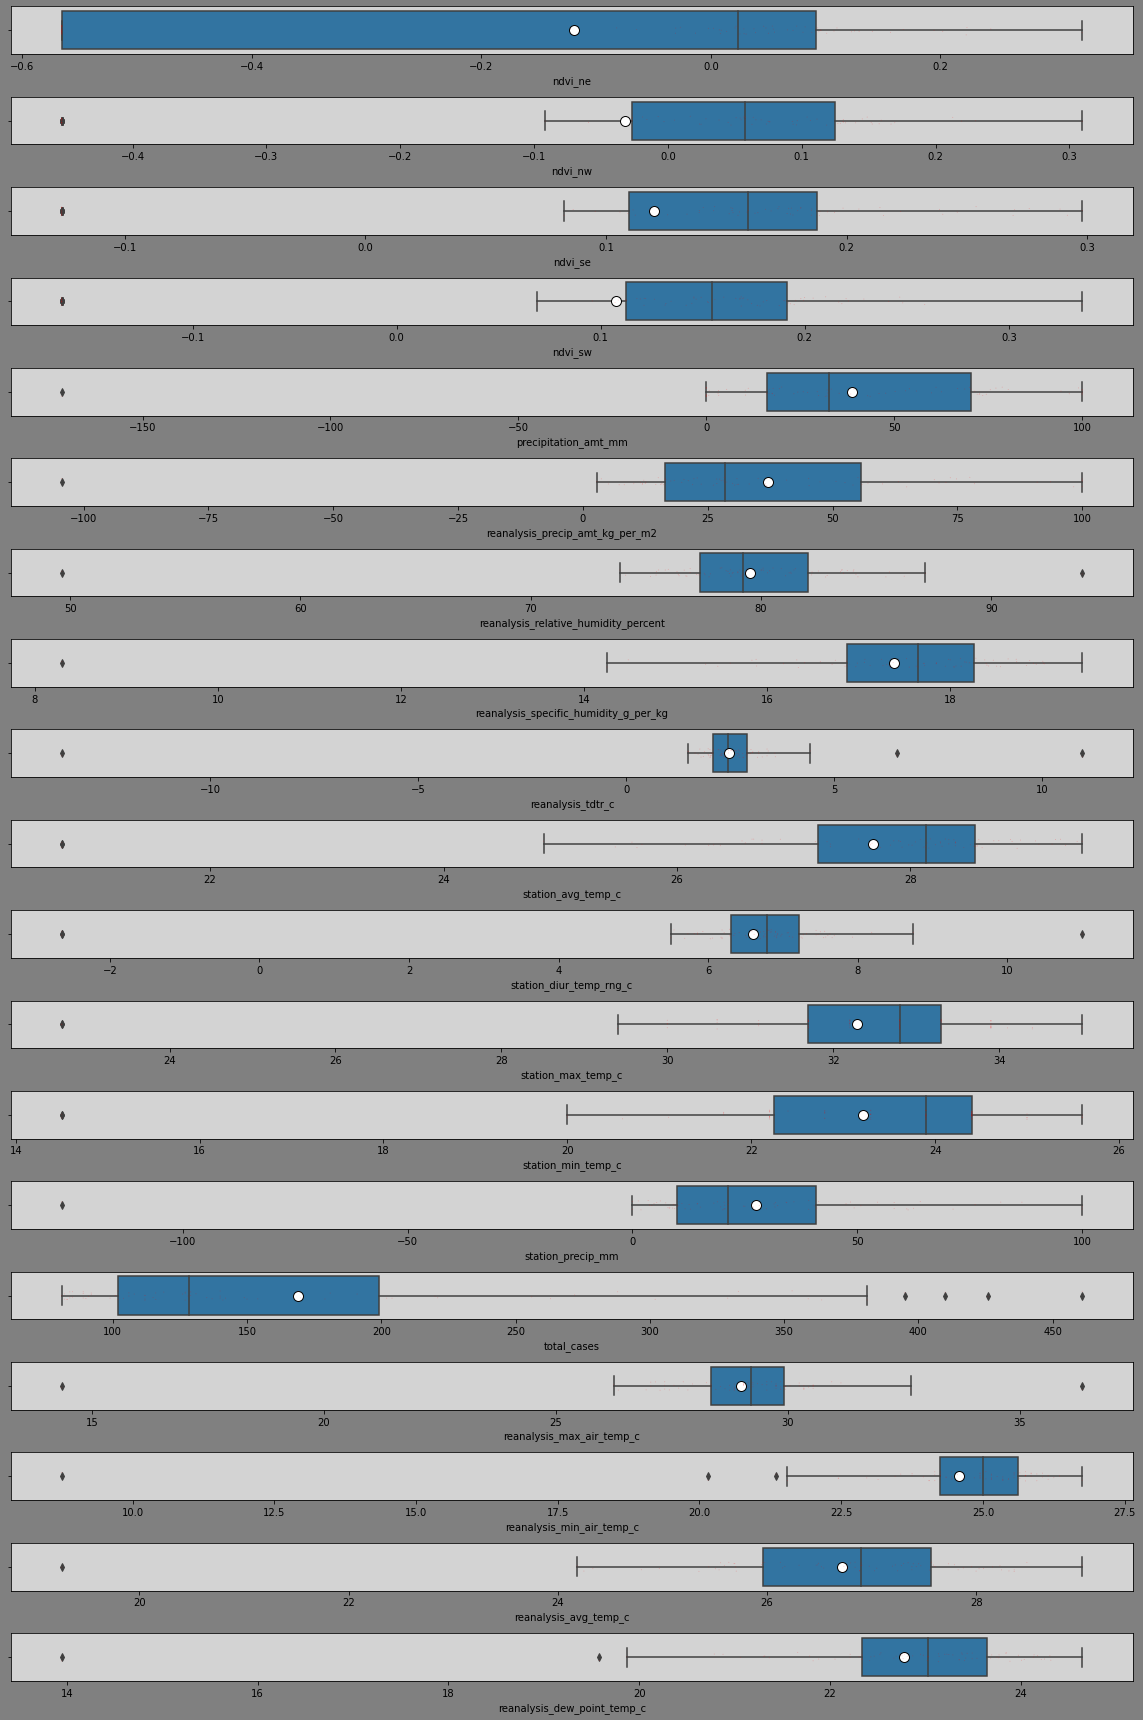

In [ ]:
multi_plot_numerical(training_features_mag_homo_extremeTarget, which_plot="boxplot", IQR_prop=2.0, bins=None, stat="probability", axes_fc="lightgray", fig_fc="gray")

## EDA 3_Selection method: features from station.

In [ ]:
reanalysis_to_drop = ['reanalysis_max_air_temp_c',
                      'reanalysis_min_air_temp_c',
                      'reanalysis_avg_temp_c',
                      'reanalysis_air_temp_c',
                      'reanalysis_tdtr_c',
                      #'reanalysis_sat_precip_amt_mm',
                      ]

def drop_features_from_reanalysis(df):
  reanalysis_to_drop = ['reanalysis_max_air_temp_c',
                        'reanalysis_min_air_temp_c',
                        'reanalysis_avg_temp_c',
                        'reanalysis_air_temp_c',
                        'reanalysis_tdtr_c',
                        #'reanalysis_sat_precip_amt_mm',
                        ]
  temp = df.copy()
  temp.drop(reanalysis_to_drop, axis=1, inplace=True)
  return temp
#   training_features_mag_homo_station = training_features_mag_homo.drop(reanalysis_to_drop, axis=1).copy()

In [ ]:
training_features_mag_homo_null_imputed_station = drop_features_from_reanalysis(training_features_mag_homo_null_imputed)

In [ ]:
training_features_mag_homo_null_imputed_station.columns

Index(['city', 'year', 'weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se',
       'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent',
       'reanalysis_specific_humidity_g_per_kg', 'station_avg_temp_c',
       'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c',
       'station_precip_mm', 'total_cases', 'reanalysis_dew_point_temp_c'],
      dtype='object')

Let's retake the picture of previous visualizations. We could conclude that diurnal features strongly correlates to temperature features and some from humidity. A very strong correlation also occurs between *reanalysis_dew_point_temp_c* and *reanalysis_specific_humidity_g_per_kg*.

We should drop out these features:

In [ ]:
def drop_features_correlated(df):
  correlated_to_drop = ['station_diur_temp_rng_c', 'reanalysis_dew_point_temp_c']
  temp = df.copy()
  temp.drop(correlated_to_drop, axis=1, inplace=True)
  return temp
#training_features_mag_homo_station_colsLowCorr = training_features_mag_homo_station.drop(['station_diur_temp_rng_c', 'reanalysis_dew_point_temp_c'], axis=1).copy()

In [ ]:
training_features_mag_homo_null_imputed_station_colsLowCorr = drop_features_correlated(training_features_mag_homo_null_imputed_station)

In [ ]:
training_features_mag_homo_null_imputed_station_colsLowCorr.columns

Index(['city', 'year', 'weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se',
       'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent',
       'reanalysis_specific_humidity_g_per_kg', 'station_avg_temp_c',
       'station_max_temp_c', 'station_min_temp_c', 'station_precip_mm',
       'total_cases'],
      dtype='object')

### Time series of different features

Plot of series without resampling or any kind of smoothing techniques like MAV

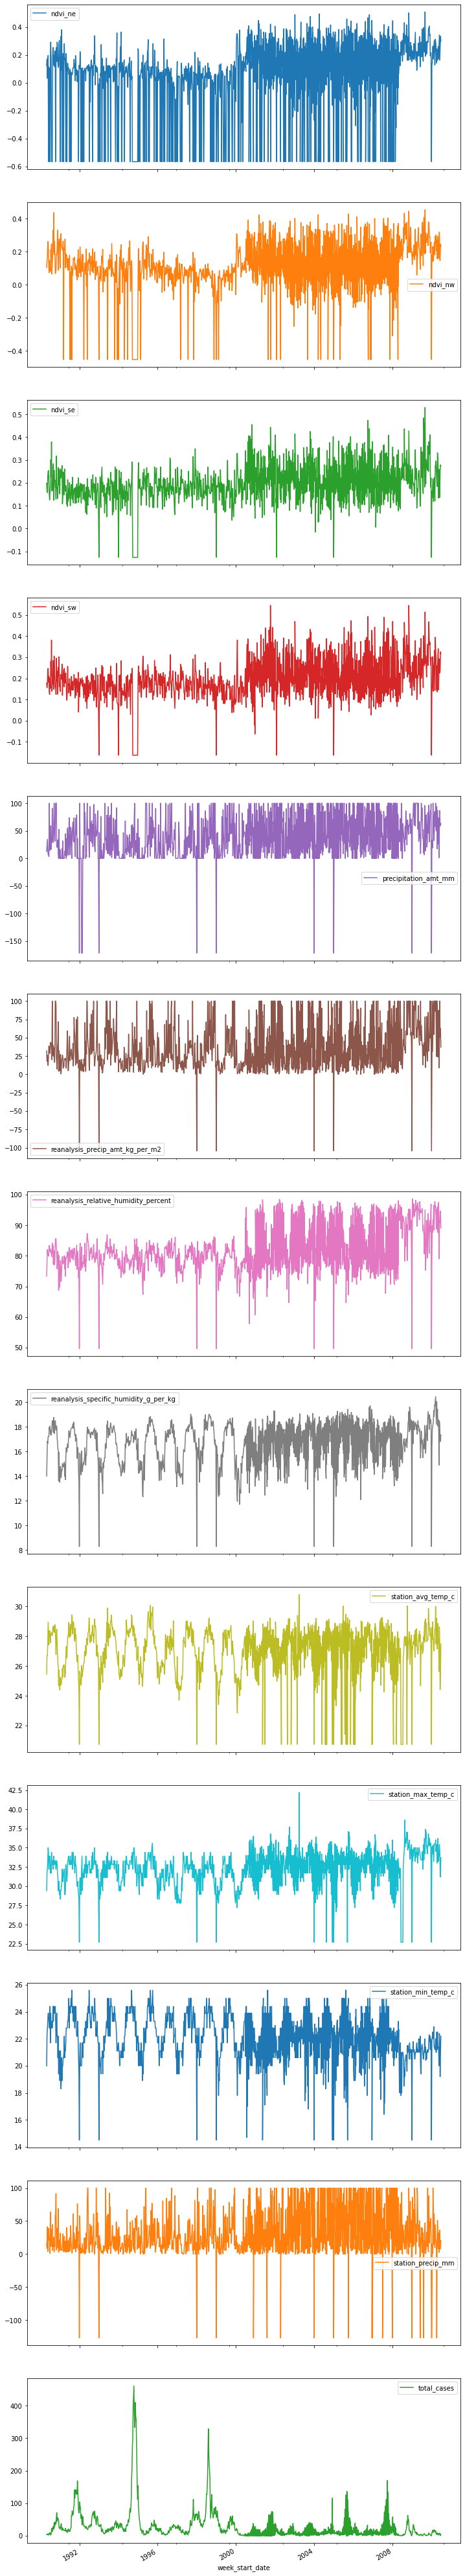

In [ ]:
_ = training_features_mag_homo_null_imputed_station_colsLowCorr.select_dtypes(float).plot(kind='line', figsize=(12, 80), subplots=True)

In [ ]:
training_features_mag_homo_null_imputed_station_colsLowCorr.reanalysis_relative_humidity_percent

week_start_date
1990-04-30    73.365714
1990-05-07    77.368571
1990-05-14    82.052857
1990-05-21    80.337143
1990-05-28    80.460000
                ...    
2010-05-28    88.765714
2010-06-04    91.600000
2010-06-11    94.280000
2010-06-18    94.660000
2010-06-25    89.082857
Name: reanalysis_relative_humidity_percent, Length: 1456, dtype: float64

In [ ]:
# Week 2 and 3
training_features_mag_homo_null_imputed_station_colsLowCorr.reanalysis_relative_humidity_percent[1:3].mean()

79.71071428574999

In [ ]:
# Week 4 and 5
training_features_mag_homo_null_imputed_station_colsLowCorr.reanalysis_relative_humidity_percent[3:5].mean()

80.39857142855

Smooth after one-week average from monday (Average measures recored in the same date)

In [ ]:
training_features_mag_homo_null_imputed_station_colsLowCorr.drop(['year', 'weekofyear'], axis=1).groupby('city').resample("w-MON").mean()

city   ndvi_ne  ...  station_precip_mm  total_cases
city week_start_date                  ...                                
0    1990-04-30        0.0  0.122600  ...               16.0          4.0
     1990-05-07        0.0  0.169900  ...                8.6          5.0
     1990-05-14        0.0  0.032250  ...               41.4          4.0
     1990-05-21        0.0  0.128633  ...                4.0          3.0
     1990-05-28        0.0  0.196200  ...                5.8          6.0
...                    ...       ...  ...                ...          ...
1    2010-05-31        1.0  0.342750  ...               27.0          5.0
     2010-06-07        1.0  0.160157  ...               36.6          8.0
     2010-06-14        1.0  0.247057  ...                7.4          1.0
     2010-06-21        1.0  0.333914  ...               16.0          1.0
     2010-06-28        1.0  0.298186  ...               20.4          4.0

[1462 rows x 14 columns]

In [ ]:
resampled_features = training_features_mag_homo_null_imputed_station_colsLowCorr.select_dtypes(float).resample("w-MON").mean()
resampled_features = pd.concat((resampled_features.index.to_series().dt.year.rename('year'), resampled_features), axis=1)

Show the distribution of samples on each year.

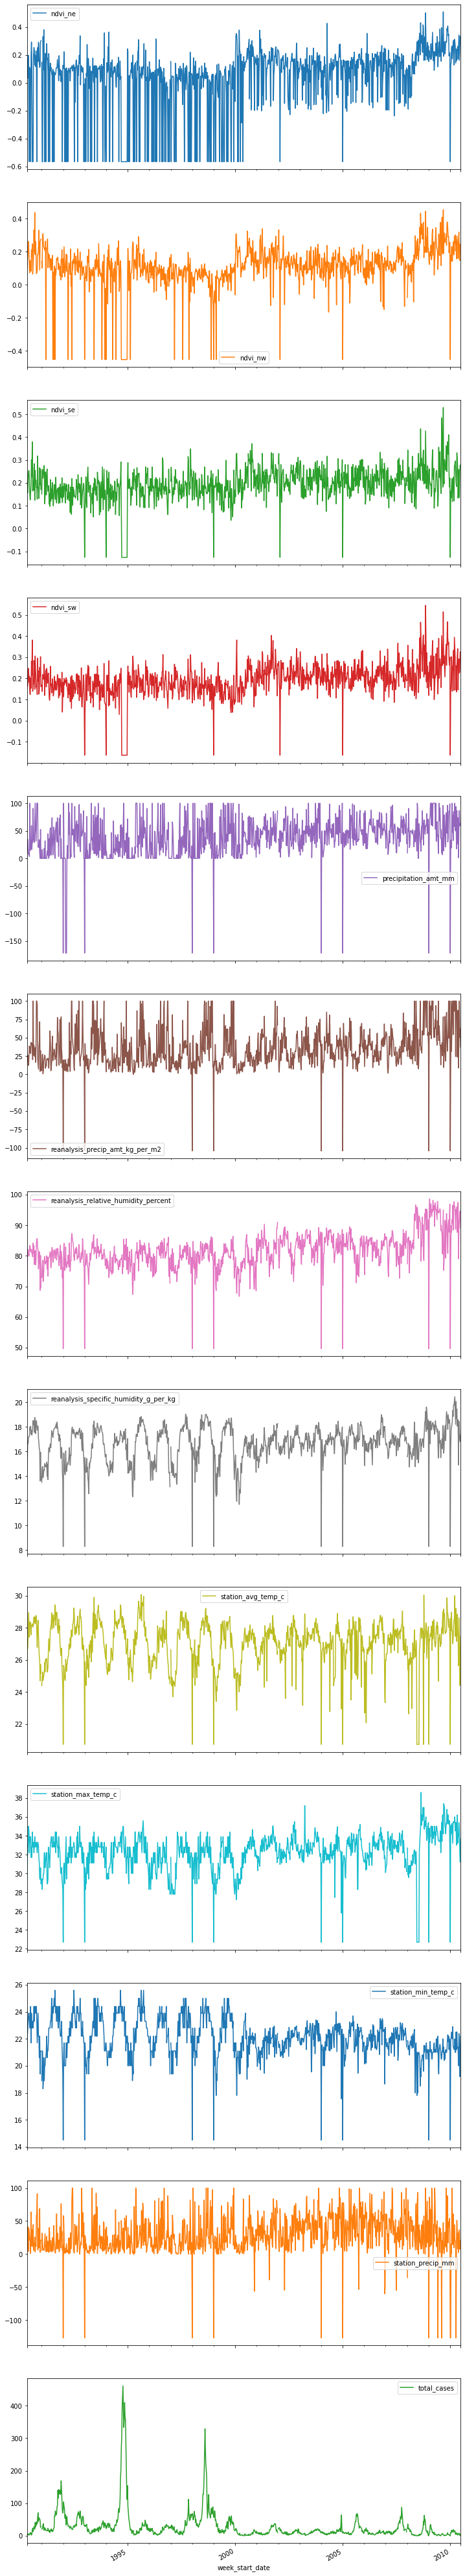

In [ ]:
_ = training_features_mag_homo_null_imputed_station_colsLowCorr.select_dtypes(float).resample("w-MON").mean().plot(kind='line', figsize=(12, 80), subplots=True)

#### Rolling windows smoothed to mean

window: 7

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8ceb5fc090>,
      dtype=object)

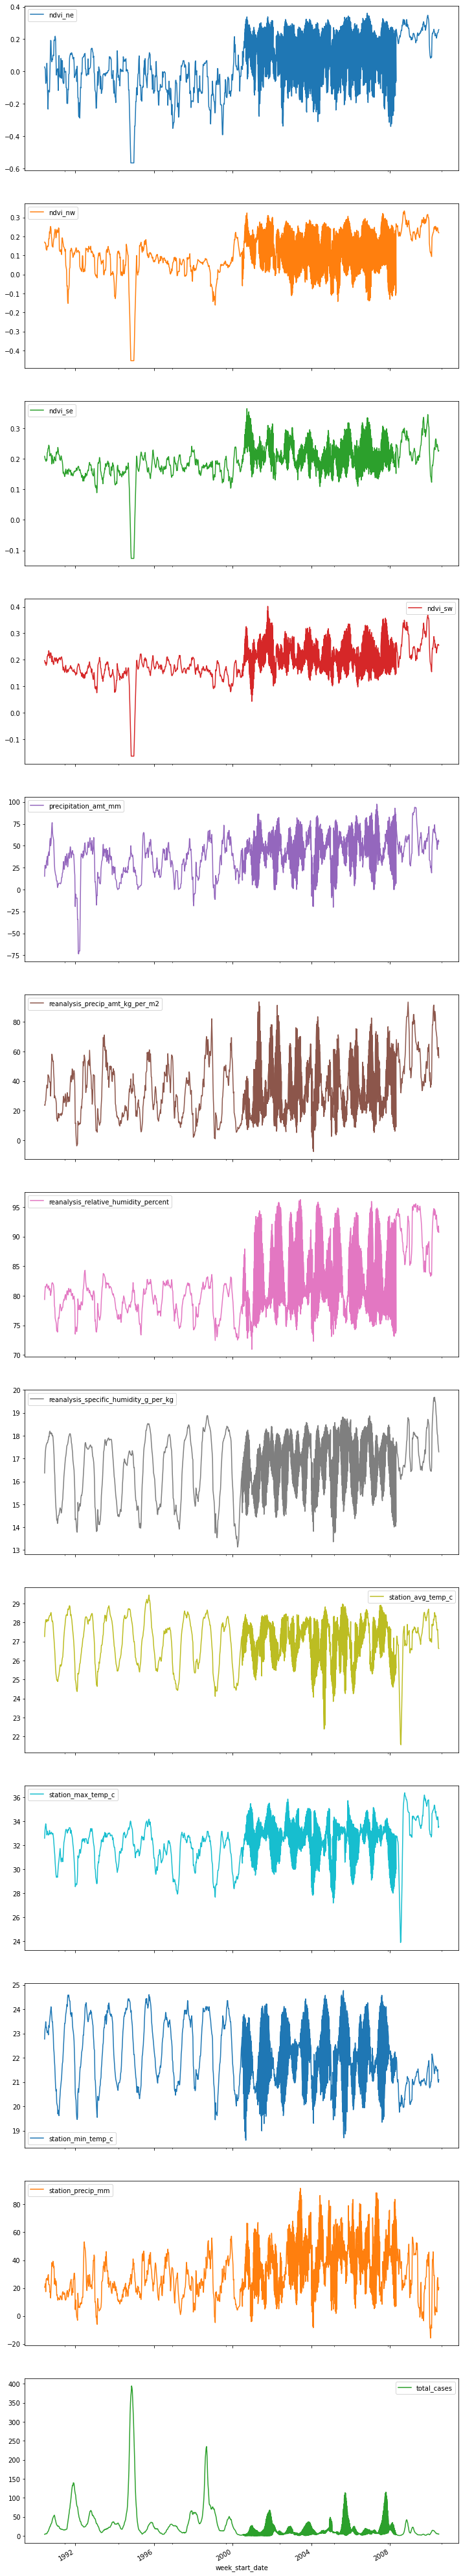

In [ ]:
training_features_mag_homo_null_imputed_station_colsLowCorr.select_dtypes(float).rolling(7).mean().plot(kind='line', figsize=(12, 80), subplots=True)

window: 14

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8ceac446d0>,
      dtype=object)

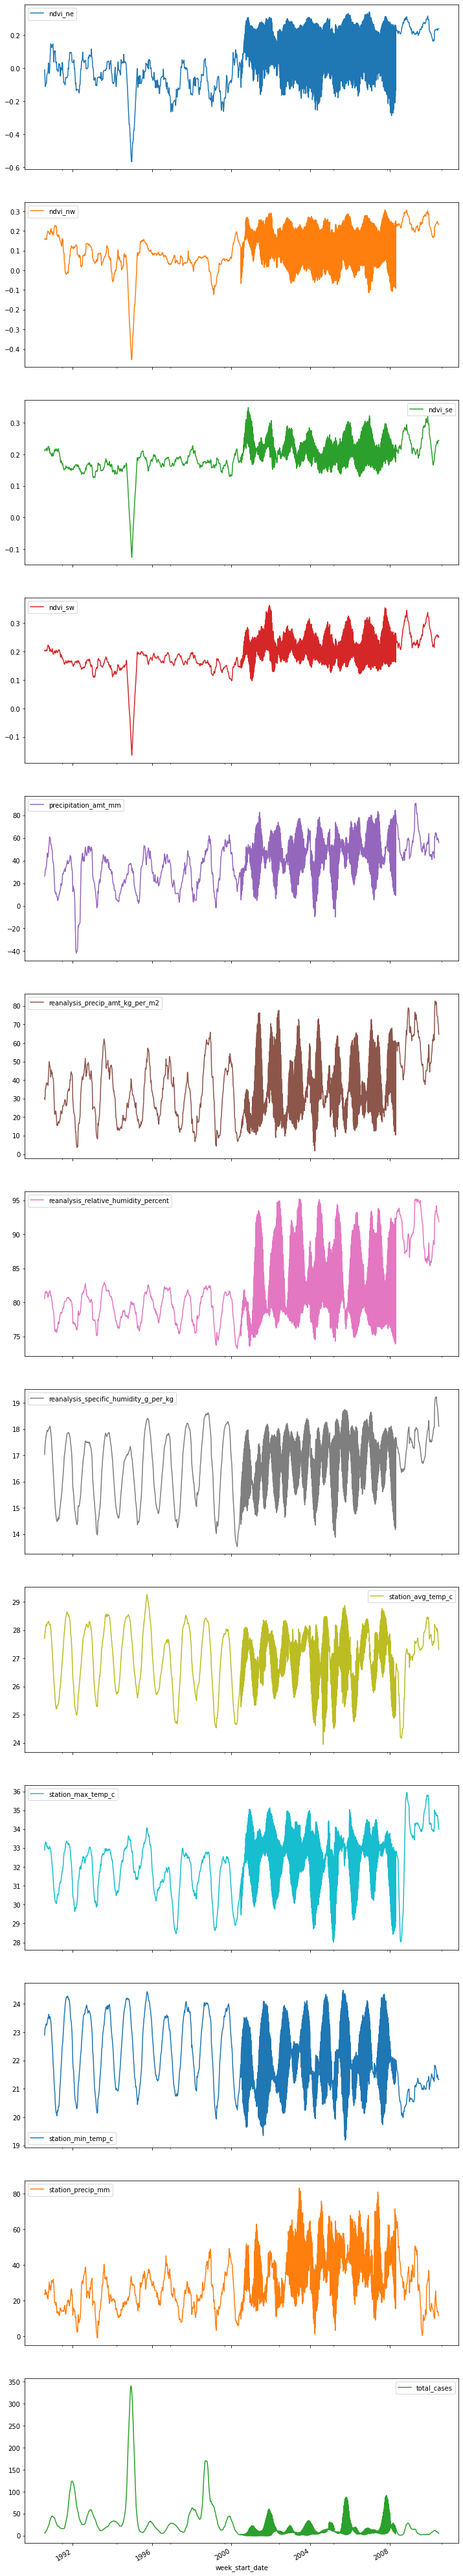

In [ ]:
training_features_mag_homo_null_imputed_station_colsLowCorr.select_dtypes(float).rolling(14).mean().plot(kind='line', figsize=(12, 80), subplots=True)

window: 30

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8ceb26ed10>,
      dtype=object)

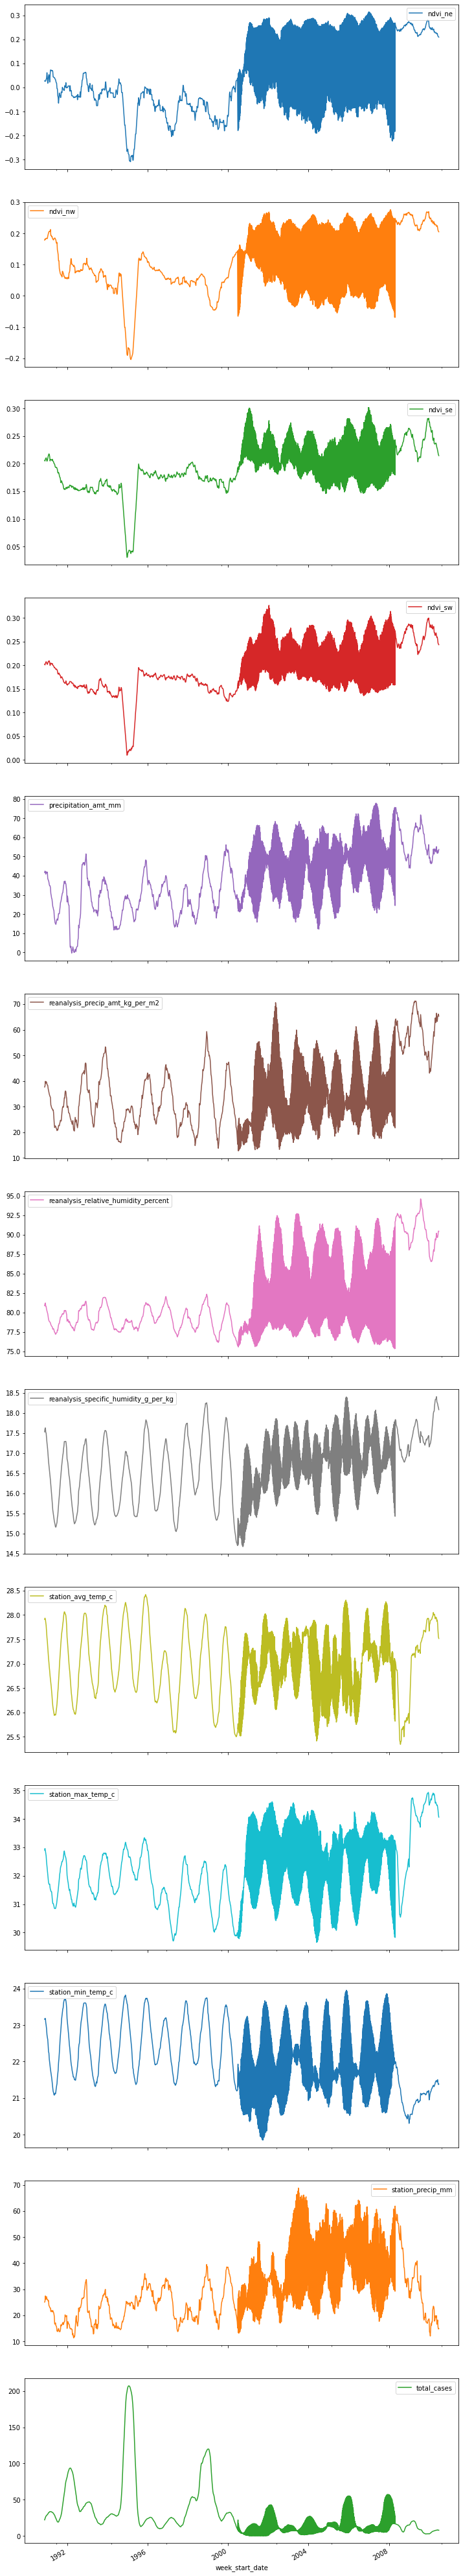

In [ ]:
training_features_mag_homo_null_imputed_station_colsLowCorr.select_dtypes(float).rolling(30).mean().plot(kind='line', figsize=(12, 80), subplots=True)

#### Autocorrelation

In [ ]:
training_features_mag_homo_null_imputed_station_colsLowCorr.select_dtypes(float).agg([lambda col: col.autocorr(1), 
                                                                         lambda col: col.autocorr(2),
                                                                         lambda col: col.autocorr(3),
                                                                         lambda col: col.autocorr(4),
                                                                         lambda col: col.autocorr(5),
                                                                         lambda col: col.autocorr(6),
                                                                         lambda col: col.autocorr(7)], axis=0).T

<lambda>  <lambda>  ...  <lambda>  <lambda>
ndvi_ne                                0.387552  0.350176  ...  0.367815  0.391901
ndvi_nw                                0.558086  0.526527  ...  0.472200  0.472406
ndvi_se                                0.421554  0.329290  ...  0.315765  0.312843
ndvi_sw                                0.488819  0.416980  ...  0.385617  0.383431
precipitation_amt_mm                   0.303031  0.239520  ...  0.209185  0.177882
reanalysis_precip_amt_kg_per_m2        0.391900  0.308015  ...  0.236454  0.203407
reanalysis_relative_humidity_percent   0.658220  0.586281  ...  0.513347  0.503169
reanalysis_specific_humidity_g_per_kg  0.690856  0.635490  ...  0.465884  0.410600
station_avg_temp_c                     0.559763  0.522125  ...  0.294076  0.269385
station_max_temp_c                     0.658703  0.570163  ...  0.410789  0.362358
station_min_temp_c                     0.619786  0.599102  ...  0.501613  0.457197
station_precip_mm                      0.193558  0.109743  ...  0.152193  0.079978
total_cases                            0.963097  0.919620  ...  0.708257  0.647367

[13 rows x 7 columns]

Stationarity

In [ ]:
training_features_mag_homo_null_imputed_station_colsLowCorr.select_dtypes(float).apply(lambda x: adfuller(x)[1], axis=0).T < 0.05

ndvi_ne                                  True
ndvi_nw                                  True
ndvi_se                                  True
ndvi_sw                                  True
precipitation_amt_mm                     True
reanalysis_precip_amt_kg_per_m2          True
reanalysis_relative_humidity_percent     True
reanalysis_specific_humidity_g_per_kg    True
station_avg_temp_c                       True
station_max_temp_c                       True
station_min_temp_c                       True
station_precip_mm                        True
total_cases                              True
dtype: bool

We see that almost all features might be considered stationaries except ndvi_ne and ndvi_nw. For these last features, it means that we couldn't use autoregressive methods to work out a base model to predict each time serie.

In [ ]:
#pd.plotting.lag_plot(training_features_mag_homo_null_imputed_station_colsLowCorr.station_min_temp_c, 1)

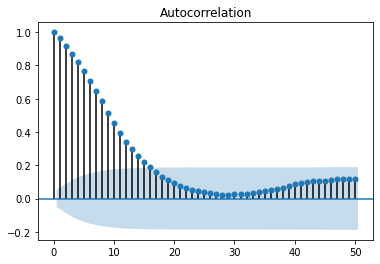

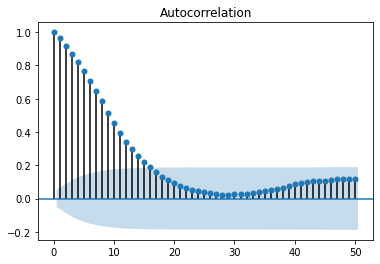

In [ ]:
# pd.plotting.autocorrelation_plot(training_features_mag_homo_null_imputed_station_colsLowCorr.total_cases)
plot_acf(training_features_mag_homo_null_imputed_station_colsLowCorr.total_cases, lags=50)

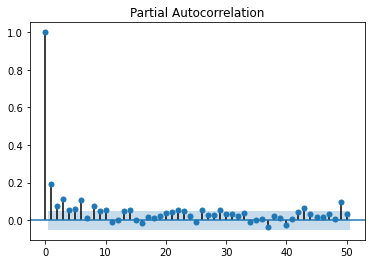

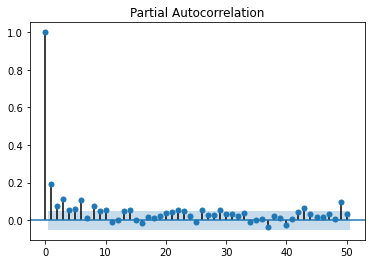

In [ ]:
plot_pacf(training_features_mag_homo_null_imputed_station_colsLowCorr.station_precip_mm, lags=50)

We see that, due to the lack of fixed patters, the autocorrelation plot show an average value of 0.2 for any lag

Fourier Analysis

In [ ]:
training_features_mag_homo_null_imputed_station_colsLowCorr.head()

city  year  ...  station_precip_mm  total_cases
week_start_date              ...                                
1990-04-30          0  1990  ...               16.0          4.0
1990-05-07          0  1990  ...                8.6          5.0
1990-05-14          0  1990  ...               41.4          4.0
1990-05-21          0  1990  ...                4.0          3.0
1990-05-28          0  1990  ...                5.8          6.0

[5 rows x 16 columns]

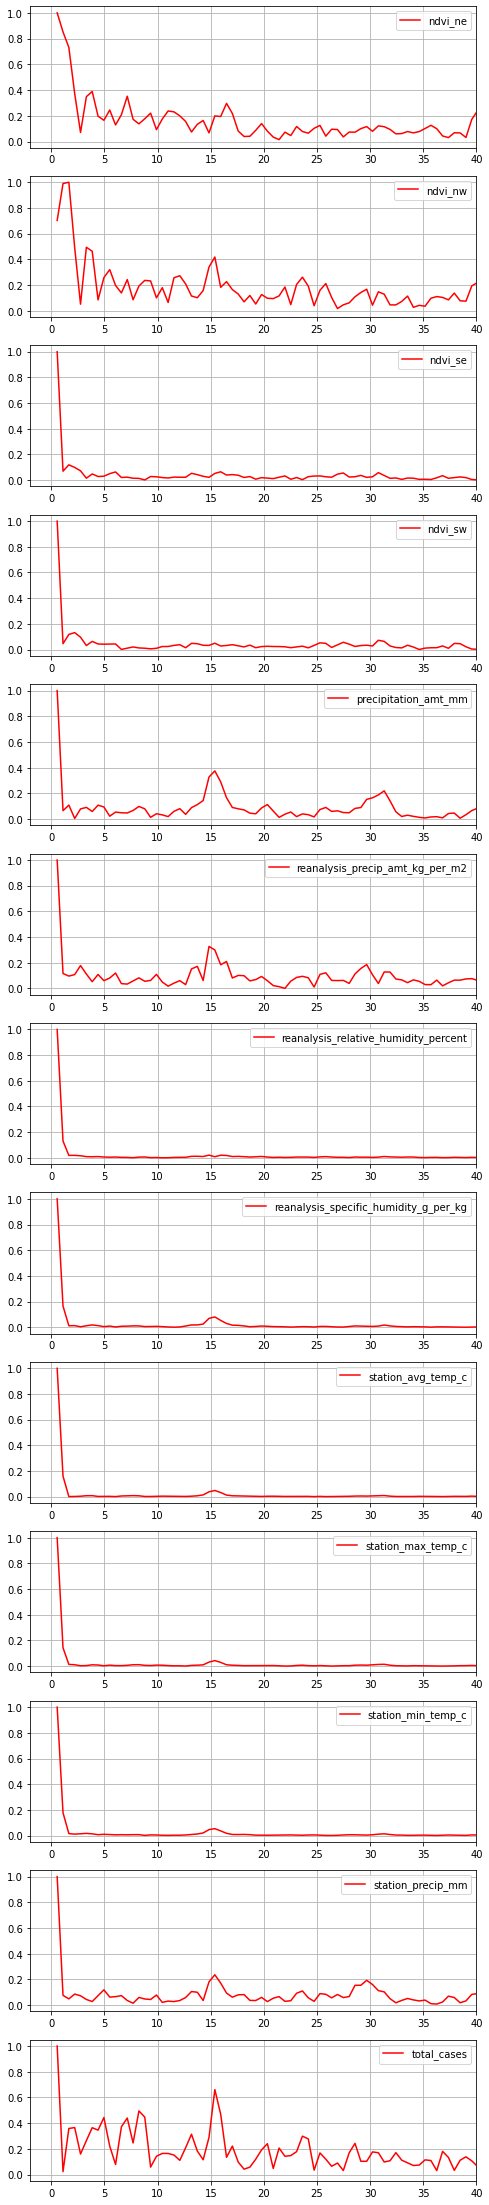

In [ ]:
from scipy.fft import fft, fftfreq
from scipy.signal import blackman
# Number of sample points
N = training_features_mag_homo_null_imputed_station_colsLowCorr.select_dtypes(float).shape[0]
cols = training_features_mag_homo_null_imputed_station_colsLowCorr.select_dtypes(float).columns
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N, endpoint=False)

fig, axes4 = plt.subplots(len(cols), 1, figsize=(8, 40))
frequencies = []

for ax, col in zip(axes4, cols):
  y = training_features_mag_homo_null_imputed_station_colsLowCorr.select_dtypes(float).loc[:, col].values
  yf = fft(y)
  w = blackman(N)
  ywf = fft(y * w)
  xf = fftfreq(N, T)[:N//2]
  freq = yf[yf >= 2.0]
  #frequencies.append()

  ywf_smooth = 2.0/N * np.abs(ywf[1:N//2])
  #plt.semilogy(xf[1:N//2], 2.0/N * np.abs(yf[1:N//2]), '-b')
  ax.plot(xf[1:N//2], ywf_smooth / ywf_smooth.max(), '-r', label=col)
  ax.legend()
  #plt.legend(['FFT', 'FFT w. window'])
  ax.set_xlim(-2, 40)
  #ax.set_ylim(0.01, (1 + 0.1) + ywf_smooth.max())
  ax.grid()
  #plt.show()

Frequencies highlighted
1. precipitation_amt_mm: ~15, 32
1. reanalysis_precip_amt_kg_per_m2: ~15
1. reanalysis_specific_humidity_g_per_kg: ~15
1. station_avg_temp_c: ~15
1. station_max_temp_c: ~15
1. station_min_temp_c: ~15
1. station_precip_mm: ~15, 30

Not important in

1. ndvi_ne
1. ndvi_nw
1. ndvi_se
1. ndvi_sw
1. reanalysis_relative_humidity
1. total_cases

## Feature engineering

Season feature

In [ ]:
def weekofyear_to_season(df, on_dummies=True):
  temp = df.index.to_series().copy()
  seasonInt_to_season = {1: "winter", 2: "spring", 3: "summer", 4: "fall"}
  if on_dummies:
    return pd.get_dummies((temp.dt.month % 12 // 3 + 1).replace(seasonInt_to_season), prefix='is', drop_first=True)
  else:
    return (temp.dt.month % 12 // 3 + 1).replace(seasonInt_to_season).rename('season')

In [ ]:
training_features_mag_homo_null_imputed_station_colsLowCorr = pd.concat((training_features_mag_homo_null_imputed_station_colsLowCorr, weekofyear_to_season(training_features_mag_homo_null_imputed_station_colsLowCorr)), axis=1)

In [ ]:
training_features_mag_homo_null_imputed_station_colsLowCorr.head()

city  year  weekofyear  ...  is_spring  is_summer  is_winter
week_start_date                          ...                                 
1990-04-30          0  1990          18  ...          1          0          0
1990-05-07          0  1990          19  ...          1          0          0
1990-05-14          0  1990          20  ...          1          0          0
1990-05-21          0  1990          21  ...          1          0          0
1990-05-28          0  1990          22  ...          1          0          0

[5 rows x 19 columns]

In [ ]:
ndvi_cols = ['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw']
ndvi_data = training_features_mag_homo_null_imputed_station_colsLowCorr.loc[:, ndvi_cols]

In [ ]:
#ndvi_data.groupby(['city']).agg(['mean', 'std']).T
#ndvi_data.groupby(['city', 'season']).agg(['mean', 'std']).T

Combination of differences for NDVI features.

In [ ]:
for n, col1 in enumerate(ndvi_cols):
  for col2 in ndvi_cols[n + 1:]:
      training_features_mag_homo_null_imputed_station_colsLowCorr[col1 + col2[4:]] = (ndvi_data.loc[:, col1] - ndvi_data.loc[:, col2])
      print(col1 + col2[4:])

ndvi_ne_nw
ndvi_ne_se
ndvi_ne_sw
ndvi_nw_se
ndvi_nw_sw
ndvi_se_sw


In [ ]:
training_features_mag_homo_null_imputed_station_colsLowCorr.describe().T

Sqrt, quadratic and cubic augmentations

In [ ]:
def add_features_functions(df, reject_target='total_cases'):
  temp = df.drop(reject_target, axis='columns').copy()

  df_to_sqrt = temp.select_dtypes(float).iloc[:, 4:].applymap(lambda x: np.sqrt(1 + x)).copy()
  df_to_sqrt.columns = [col + '_sqrt' for col in df_to_sqrt.columns]

  #df_to_square = temp.select_dtypes(float).applymap(np.square).copy()
  #df_to_square.columns = [col + '_square' for col in df_to_square.columns]

  return pd.concat((df.copy(), df_to_sqrt), axis=1)

In [ ]:
training_features_mag_homo_null_imputed_station_colsLowCorr.min()

city                                        0.000000
year                                     1990.000000
weekofyear                                  1.000000
ndvi_ne                                    -0.565650
ndvi_nw                                    -0.452933
ndvi_se                                    -0.126188
ndvi_sw                                    -0.164112
precipitation_amt_mm                     -171.505000
reanalysis_precip_amt_kg_per_m2          -104.380000
reanalysis_relative_humidity_percent       49.635000
reanalysis_specific_humidity_g_per_kg       8.293929
station_avg_temp_c                         20.728571
station_max_temp_c                         22.700000
station_min_temp_c                         14.500000
station_precip_mm                        -126.900000
total_cases                                 0.000000
is_spring                                   0.000000
is_summer                                   0.000000
is_winter                                   0.

In [ ]:
training_features_mag_homo_null_imputed_station_colsLowCorr = add_features_functions(training_features_mag_homo_null_imputed_station_colsLowCorr, reject_target='total_cases')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


Correlations of new features. Feature extraction in case of low correlation.

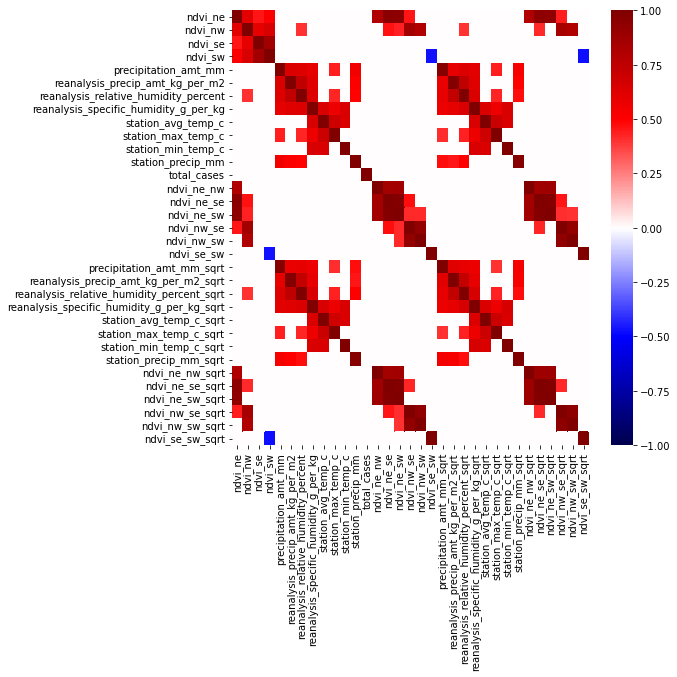

In [ ]:
_, axes2 = plt.subplots(1, 1, figsize=(8, 8))

selected_columns = ['total_cases'] + [col for col in training_features_mag_homo_null_imputed_station_colsLowCorr if '_sqrt' in col]
corr_limit = 0.4
x = features_for_model.select_dtypes(float).corr()
#x = features_for_model.loc[:, selected_columns].corr()
y = x.where((x >= corr_limit) | (x <= - corr_limit), 0.0)

heatmap3 = sns.heatmap(y, ax=axes2, cmap='seismic', vmin=-1.0, vmax=1.0)

In [ ]:
len(training_features_mag_homo_null_imputed_station_colsLowCorr.select_dtypes(float).columns)

33

Method of extraction: limit of correlations

In [ ]:
correlated_cols, low_corr_cols = detect_uncorrelated(training_features_mag_homo_null_imputed_station_colsLowCorr.select_dtypes(float), threshold_lim=2)
len(correlated_cols)

27

total_cases                0.168383
station_max_temp_c_sqrt    0.197503
station_min_temp_c_sqrt    0.104823
station_precip_mm_sqrt     0.073209
ndvi_nw_sw_sqrt            0.168383
ndvi_se_sw_sqrt            0.197503
dtype: float64

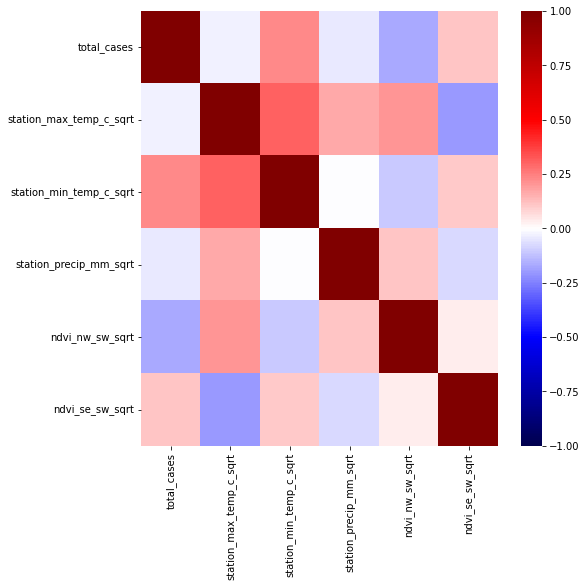

In [ ]:
_, axes2 = plt.subplots(1, 1, figsize=(8, 8))

selected_columns = low_corr_cols
corr_limit = 0.1
x = training_features_mag_homo_null_imputed_station_colsLowCorr.loc[:, selected_columns].corr()
#y = x.where((x >= corr_limit) | (x <= - corr_limit), 0.0)

heatmap3 = sns.heatmap(x, ax=axes2, cmap='seismic', vmin=-1.0, vmax=1.0)
x.mul(-1).max()